## Package Installation

In [1]:
!pip install adversarial-robustness-toolbox[all] pyod pyyaml h5py scikit-learn-intelex
!pip install -U scikit-learn
!pip install -U pandas
!pip install https://download.pytorch.org/whl/cu118/torch-2.0.0%2Bcu118-cp39-cp39-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 KB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 KB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.

## Imports

In [2]:
############
# Built-in #
############
import os
import warnings
import gc

###############
# Third-party #
###############
from art.attacks.evasion import DecisionTreeAttack, FastGradientMethod
from art.estimators.classification import SklearnClassifier

from IPython.display import clear_output
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyod.models.vae import VAE
import seaborn as sns

from sklearn.datasets import fetch_kddcup99
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, LeaveOneOut, train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler

from sklearnex.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

%matplotlib inline

In [3]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Notebook Options

In [4]:
################################
# Anomaly Detector VAE Options #
################################
# Base location to save models and checkpoints
base_folder = '/content/drive/MyDrive/Colab Notebooks/SEAS 6402'

# Anomaly detector file name
anomaly_detector_file = 'anomaly_detector_new_v5_kdd.joblib'

# Whether to load and use an existing anomaly detector or not
use_existing_anomaly_detector = True

#################
# WCGAN Options #
#################
# WCGAN file name for checkpoints
wcgan_file = 'wcgan_model_new_v5_kdd'

# NOTE: If BOTH options set to `False` below,
#       it will just load the existing model
# Whether to train a new WCGAN model
train_new_wcgan = False

# Whether to continue training from a checkpointed WCGAN model
continue_train_wcgan = False

# After how many epochs to save checkpoints
checkpoint_frequency_wcgan = 1

# Number of epochs finished before training was stopped
# When continuing training, the epochs to train will be calculated
# as num_original_epochs - num_epochs_done
num_epochs_done_wcgan = 87

#######################
# Vanilla GAN Options #
#######################
# Vanilla GAN file name for checkpoints
vgan_file = 'vgan_model_new_v5_kdd'

# NOTE: If BOTH options set to `False` below,
#       it will just load the existing model
# Whether to train a new GAN model
train_new_vgan = True

# Whether to continue training from a checkpointed GAN model
continue_train_vgan = False

# After how many epochs to save checkpoints
checkpoint_frequency_vgan = 1

# Number of epochs finished before training was stopped
# When continuing training, the epochs to train will be calculated
# as num_original_epochs - num_epochs_done
num_epochs_done_vgan = 95

## Baseline Model Creation - KDDCup99 Dataset

In [5]:
 X_cov, y_cov = fetch_kddcup99(
    subset = 'SA',
    random_state = 1,
    shuffle = True,
    return_X_y = True,
    as_frame = True
)
 
data = pd.merge(X_cov, y_cov, left_index = True, right_index = True)
data['labels'] = data['labels'].apply(lambda x: x.decode('utf-8'))
data = data[~data.labels.isin(['nmap.', 'imap.', 'guess_passwd.'])]

X_cov = data.drop(['labels'], axis = 1)
y_cov = data['labels']

display(X_cov.head())
display(y_cov.head())

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,b'tcp',b'http',b'SF',290,1091,0,0,0,0,...,90,255,1.0,0.0,0.01,0.03,0.0,0.0,0.0,0.0
1,0,b'tcp',b'http',b'REJ',0,0,0,0,0,0,...,1,255,1.0,0.0,1.0,0.22,0.0,0.0,1.0,1.0
2,0,b'tcp',b'http',b'SF',297,1160,0,0,0,0,...,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01
3,0,b'tcp',b'smtp',b'SF',1180,398,0,0,0,0,...,29,67,0.97,0.07,0.03,0.03,0.0,0.0,0.0,0.0
4,0,b'icmp',b'urh_i',b'SF',36,0,0,0,0,0,...,159,59,0.37,0.04,0.37,0.0,0.0,0.0,0.0,0.0


0    normal.
1    normal.
2    normal.
3    normal.
4    normal.
Name: labels, dtype: object

### Normal Train/Test

===============Logistic Regression================
              precision    recall  f1-score   support

           0       0.05      1.00      0.09         3
           1       0.60      1.00      0.75         3
           2       0.99      1.00      1.00       191
           3       1.00      0.99      1.00     19456
           4       0.25      1.00      0.40         1
           5       0.50      1.00      0.67         1
           6       0.75      1.00      0.86         3
           7       0.99      1.00      0.99       469
           8       1.00      1.00      1.00         2
           9       0.03      1.00      0.06         2

    accuracy                           0.99     20131
   macro avg       0.62      1.00      0.68     20131
weighted avg       1.00      0.99      1.00     20131


==================Decision Tree===================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      

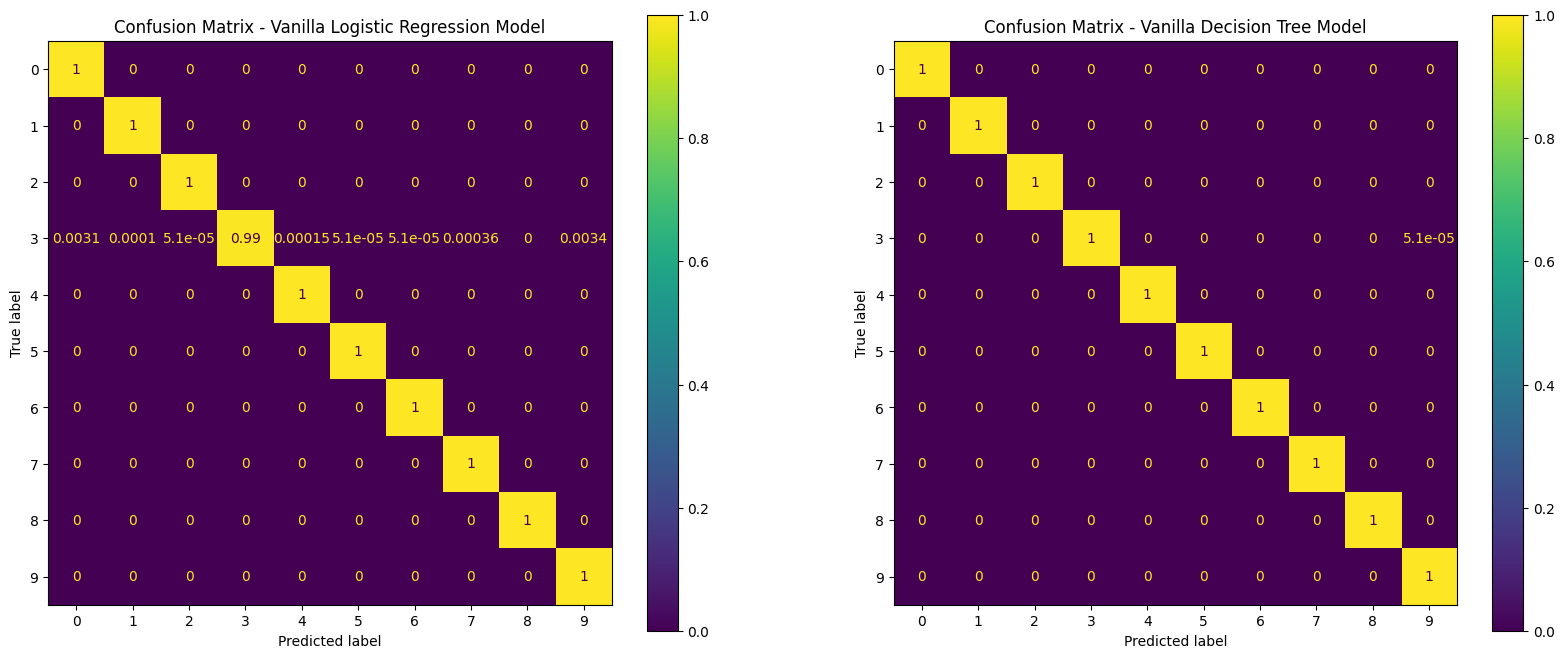

In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_cov, 
    y_cov,
    test_size = 0.2,
    stratify = y_cov,
    random_state = 1
)

X_train = X_train.drop(['protocol_type', 'service', 'flag'], axis = 1)
X_test = X_test.drop(['protocol_type', 'service', 'flag'], axis = 1)

# One-hot encode labels for ART to use properly
lb = LabelBinarizer()
lb.fit(y_cov.unique())
y_train_ohe = lb.transform(y_train)
y_test_ohe = lb.transform(y_test)

# Create min-max scaler to transform data between -1 and 1
scaler = MinMaxScaler(feature_range = (-1, 1))

# Train a vanilla decision tree and logistic regression classifiers
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    lr = SklearnClassifier(
        model = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
    )
    # Scale training data before fitting LR
    # scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    lr.fit(X_train_scaled, y_train_ohe);

    dt = SklearnClassifier(
        model = DecisionTreeClassifier(class_weight = 'balanced')
    )
    X_train_scaled = scaler.fit_transform(X_train)
    dt.fit(X_train_scaled, y_train_ohe);

# Get predictions
y_pred_ohe_lr = lr.predict(scaler.transform(X_test))
y_pred_lr = np.argmax(y_pred_ohe_lr, axis = 1) 
print('Logistic Regression'.center(50, '='))
print(classification_report(np.argmax(y_test_ohe, axis = 1), y_pred_lr))

y_pred_ohe_dt = dt.predict(scaler.transform(X_test))
y_pred_dt = np.argmax(y_pred_ohe_dt, axis = 1)
print('\n' + 'Decision Tree'.center(50, '='))
print(classification_report(np.argmax(y_test_ohe, axis = 1), y_pred_dt))

# Get confusion matrices
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
axes[0].set_title('Confusion Matrix - Vanilla Logistic Regression Model');
ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test_ohe, axis = 1), 
    y_pred_lr, 
    normalize = 'true', 
    ax = axes[0]
);

axes[1].set_title('Confusion Matrix - Vanilla Decision Tree Model');
ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test_ohe, axis = 1), 
    y_pred_dt, 
    normalize = 'true', 
    ax = axes[1]
);

### Adversarial Test

Decision tree attack:   0%|          | 0/20131 [00:00<?, ?it/s]

===============Logistic Regression================
              precision    recall  f1-score   support

           0       0.00      0.50      0.00         6
           1       0.03      0.50      0.06         6
           2       0.95      0.89      0.92       382
           3       0.97      0.50      0.66     38912
           4       0.00      0.50      0.00         2
           5       0.01      0.50      0.02         2
           6       0.01      0.50      0.02         6
           7       0.73      0.50      0.59       938
           8       1.00      1.00      1.00         4
           9       0.00      0.50      0.00         4

    accuracy                           0.50     40262
   macro avg       0.37      0.59      0.33     40262
weighted avg       0.97      0.50      0.66     40262


==================Decision Tree===================
              precision    recall  f1-score   support

           0       0.00      0.50      0.00         6
           1       1.00      

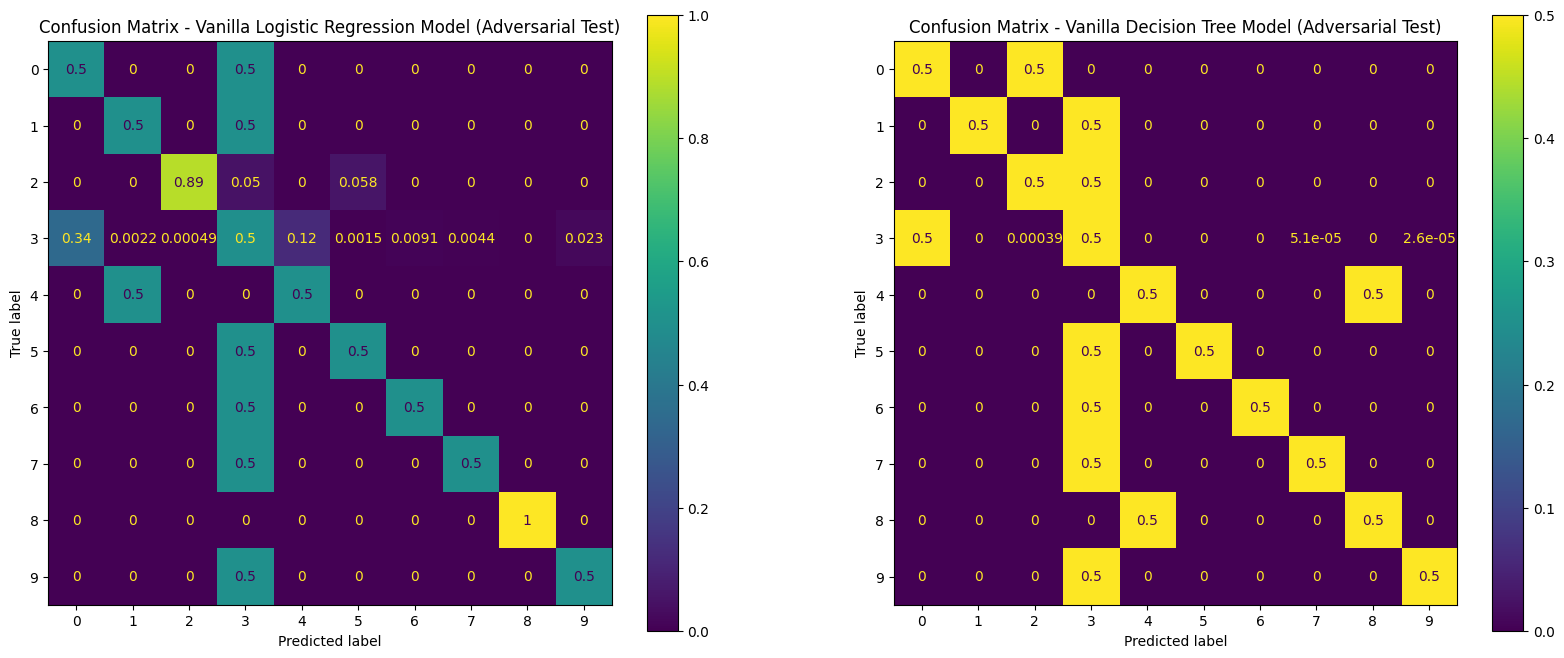

In [7]:
# Generate adversarial test examples
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    attack_lr = FastGradientMethod(minimal = True, estimator = lr)
    attack_dt = DecisionTreeAttack(classifier = dt)

    X_test_adv_only_lr = attack_lr.generate(x = scaler.transform(X_test.values))
    X_test_adv_only_dt = attack_dt.generate(x = scaler.transform(X_test.values))

    # Combine adversarial examples with real examples
    X_test_adv_lr = np.concatenate([X_test_adv_only_lr, scaler.transform(X_test.values)])
    X_test_adv_dt = np.concatenate([X_test_adv_only_dt, scaler.transform(X_test.values)])
    y_test_adv = np.concatenate([y_test, y_test])
    y_test_adv_ohe = lb.transform(y_test_adv)

    # Evaluate the ART classifier on combined real and adversarial test examples
    y_pred_adv_ohe_lr = lr.predict(X_test_adv_lr)
    y_pred_adv_lr = np.argmax(y_pred_adv_ohe_lr, axis = 1)
    print('Logistic Regression'.center(50, '='))
    print(classification_report(np.argmax(y_test_adv_ohe, axis = 1), y_pred_adv_lr))

    y_pred_adv_ohe_dt = dt.predict(X_test_adv_dt)
    y_pred_adv_dt = np.argmax(y_pred_adv_ohe_dt, axis = 1)
    print('\n' + 'Decision Tree'.center(50, '='))
    print(classification_report(np.argmax(y_test_adv_ohe, axis = 1), y_pred_adv_dt))

# Get confusion matrices
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
axes[0].set_title('Confusion Matrix - Vanilla Logistic Regression Model (Adversarial Test)');
ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test_adv_ohe, axis = 1), 
    y_pred_adv_lr, 
    normalize = 'true', 
    ax = axes[0]
);

axes[1].set_title('Confusion Matrix - Vanilla Decision Tree Model (Adversarial Test)');
ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test_adv_ohe, axis = 1), 
    y_pred_adv_dt, 
    normalize = 'true', 
    ax = axes[1]
);

## Anomaly Detection Model - Variational Autoencoder (VAE)

In [8]:
vae_train = X_train.copy()
vae_test = X_test.copy()

In [9]:
# Overwrite PyOD VAE decision_function function to suppress constant
# output printing during prediction time.
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from pyod.utils.stat_models import pairwise_distances_no_broadcast

class VAEModified(VAE):
    def decision_function(self, X):
        '''Replacement function to suppress predict() output.
        '''
        check_is_fitted(self, ['model_', 'history_'])
        X = check_array(X)

        if self.preprocessing:
            X_norm = self.scaler_.transform(X)
        else:
            X_norm = np.copy(X)

        # Predict on X and return the reconstruction errors
        pred_scores = self.model_.predict(X_norm, verbose = 0)

        return pairwise_distances_no_broadcast(X_norm, pred_scores)

if not use_existing_anomaly_detector:
    anomaly_detector = VAEModified(
        batch_size = 1024,
        validation_size = 0.2,
        epochs = 100
    )

    anomaly_detector.fit(scaler.transform(vae_train));

### Model Saving/Loading

In [10]:
if not use_existing_anomaly_detector:
    # Save model. Using workaround from here: 
    # https://github.com/yzhao062/pyod/issues/328#issuecomment-917192704
    # since saving the Lambda layer fails
    anomaly_detector.model_.save(f'{base_folder}')
    anomaly_detector.model_ = None
    joblib.dump(anomaly_detector, f'{base_folder}/{anomaly_detector_file}');

# Load model
def sampling(args):
    '''Copy of internal sampling function of PyOD's VAE for loading.'''
    z_mean, z_log = args
    batch = K.shape(z_mean)[0]  # batch size
    dim = K.int_shape(z_mean)[1]  # latent dimension
    epsilon = K.random_normal(shape = (batch, dim))  # mean=0, std=1.0

    return z_mean + K.exp(0.5 * z_log) * epsilon

anomaly_detector = joblib.load(f'{base_folder}/{anomaly_detector_file}')
anomaly_detector.model_ = keras.models.load_model(
    f'{base_folder}', 
    custom_objects = {'sampling': sampling}
)

In [11]:
scores = anomaly_detector.predict_proba(scaler.transform(vae_test))
outliers = scores[
    np.where(scores[:, 1] > 0.5)
]
num_outliers = outliers.shape[0]
total = scores.shape[0]

In [12]:
# Best results should be 0 found in test data (0%)
print(f'{num_outliers} outliers found in test data! ({num_outliers / total * 100:.2f}%)')

2 outliers found in test data! (0.01%)


In [13]:
scores = anomaly_detector.predict_proba(X_test_adv_only_lr)
outliers = scores[
    np.where(scores[:, 1] > 0.5)
]
num_outliers = outliers.shape[0]
total = scores.shape[0]

In [14]:
# Best results should be 116203 found in adversarial data (100%)
print(f'{num_outliers} outliers found in LR adversarial data! ({num_outliers / total * 100:.2f}%)')

1 outliers found in LR adversarial data! (0.00%)


In [15]:
scores = anomaly_detector.predict_proba(X_test_adv_only_dt)
outliers = scores[
    np.where(scores[:, 1] > 0.5)
]
num_outliers = outliers.shape[0]
total = scores.shape[0]

In [16]:
# Best results should be 116203 found in adversarial data (100%)
print(f'{num_outliers} outliers found in DT adversarial data! ({num_outliers / total * 100:.2f}%)')

1 outliers found in DT adversarial data! (0.00%)


## GAN Models

In [17]:
class TrainingPlot(keras.callbacks.Callback):
    '''Callback function to dynamically plot training losses.

    Code is from https://github.com/kapil-varshney/utilities/blob/master/training_plot/training_plot_ex_with_cifar10.ipynb
    and slightly modified for this notebook.
    '''
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs and losses 
        self.d_loss = []
        self.g_loss = []
        self.logs = []
    
    def on_epoch_end(self, epoch, logs={}):
        # Append the logs and losses to the lists
        self.logs.append(logs)
        self.d_loss.append(logs.get('d_loss'))
        self.g_loss.append(logs.get('g_loss'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.d_loss) > 1:
            # Clear the previous plot
            clear_output(wait = True)
            N = np.arange(1, len(self.d_loss) + 1)
            
            with sns.axes_style('darkgrid'):
                fig, ax1 = plt.subplots()
                ax2 = ax1.twinx()
                sns.lineplot(x = N, y = self.d_loss, ax = ax1, color = 'orange')
                sns.lineplot(x = N, y = self.g_loss, ax = ax2, color = 'dodgerblue')
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Discriminator Loss', color = 'orange')
                ax2.set_ylabel('Generator Loss', color = 'dodgerblue')
                plt.title('GAN Training Loss')
                plt.show()

In [18]:
class SaveOrLoadModel(keras.callbacks.Callback): 
    '''Callback function to do model saving/loading.

    This callback function is needed because the built-in Keras
    ModelCheckpoint callback does not work with the custom models
    built in this notebook.

    By default, only the last three checkpoints will be kept.

    Attributes
    ----------
    checkpoint_path : str
        Path to save model checkpoints.

    restore_from_checkpoint : bool, default=False
        If `True`, the latest checkpoint (assuming it exists),
        will be loaded from `checkpoint_path`.

    skip_train : bool, default=False
        If `True`, the model will not be trained. This is useful
        for just loading in a checkpoint without having to train it.

    checkpoint_frequency : int, default=1
        After how many epochs to create a checkpoint.
    '''
    def __init__(
        self, 
        checkpoint_path='.', 
        restore_from_checkpoint=False, 
        skip_train=False, 
        checkpoint_frequency=1
    ):
        super(SaveOrLoadModel, self).__init__()
        self.checkpoint_path = checkpoint_path
        self.restore_from_checkpoint = restore_from_checkpoint
        self.checkpoint_frequency = checkpoint_frequency
        self.skip_train = skip_train

    def on_train_begin(self, logs=None):
        self._ckpt = tf.train.Checkpoint(
            generator = self.model.generator,
            discriminator = self.model.discriminator,
            g_optimizer = self.model.g_optimizer,
            d_optimizer = self.model.d_optimizer
        )

        self._ckpt_manager = tf.train.CheckpointManager(
            self._ckpt, 
            self.checkpoint_path, 
            max_to_keep = 3
        )

        if self._ckpt_manager.latest_checkpoint:
            if self.restore_from_checkpoint or self.skip_train:
                print(f'\nLoading checkpoint {self._ckpt_manager.latest_checkpoint}...', end = '')
                self._ckpt.restore(self._ckpt_manager.latest_checkpoint)
                print('done!')

            # Skip the training phase and just load the latest checkpoints
            if self.skip_train: self.model.stop_training = True

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.checkpoint_frequency == 0: 
            if not self.model.stop_training:
                chkpoint_path = self._ckpt_manager.save()
                print(f'\nSaved checkpoint to {chkpoint_path}!')

        gc.collect();

### GAN Model 1: WCGAN-GP

In [19]:
gan_train_x = pd.DataFrame(scaler.transform(X_train.copy()))
gan_train_y = keras.utils.to_categorical(np.argmax(y_train_ohe, axis = 1)) 

display(gan_train_x.head())
display(gan_train_y[:5])

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-1.000000,-0.999644,-0.999676,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-0.866667,1.000000,1.00,-1.00,-0.88,-0.96,-1.0,-1.0,-1.0,-1.0
1,-0.999863,-0.998950,-0.999872,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,0.521569,-0.262745,-0.28,-0.92,-0.98,-0.96,-1.0,-1.0,-1.0,-1.0
2,-1.000000,-0.991636,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-0.192157,-0.050980,0.52,-0.90,0.52,-0.96,-1.0,-1.0,-1.0,-1.0
3,-1.000000,-0.999962,-0.999984,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.301961,-0.333333,0.92,-0.94,-0.98,-1.00,-1.0,-1.0,-1.0,-1.0
4,-0.906805,-0.999866,-0.999959,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.000000,-0.992157,-1.00,0.72,1.00,-1.00,-1.0,-1.0,-1.0,-1.0


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [20]:
num_cols = gan_train_x.shape[1]
latent_dim = 500
generator_input_size = latent_dim + y_train.nunique()
discriminator_input_size = num_cols + y_train.nunique()

generator = keras.models.Sequential([
    # Layer block 1
    keras.layers.Dense(64, input_shape = [generator_input_size]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.2),
    # Layer block 2
    keras.layers.Dense(128),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.2),
    # Layer block 3
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.2),
    # Layer block 4
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.2),
    # Final output
    keras.layers.Dense(num_cols, activation = 'tanh')
])

discriminator = keras.models.Sequential([
    # Layer block 1                                
    keras.layers.Dense(256, input_shape = [discriminator_input_size]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.5),
    # Layer block 2
    keras.layers.Dense(128),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.5),
    # Layer block 3
    keras.layers.Dense(64),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.5),
    # Final output
    keras.layers.Dense(1)
])

In [21]:
class WCGAN_GP_VAE(keras.Model):
    '''Implementation of WCGAN-GP with VAE scaling.

    This implementation is based on a combination of 
    https://keras.io/examples/generative/wgan_gp/#create-the-wgangp-model and
    https://keras.io/examples/generative/conditional_gan/. 

    This follows the standard implementation of WCGAN-GP with the added
    modification of allowing a pre-trained VAE to sit between the generator
    and discriminator to appropriately scale the inputs to the discriminator
    by the probability of being non-anomalous.

    Attributes
    ----------
    discriminator : Keras Sequential model
        Discriminator model for the GAN

    generator : Keras Sequential model
        Generator model for the GAN

    latent_dim : int
        Number of latent dimensions for input into the generator

    anomaly_detector : PyOD VAE model
        Pre-trained VAE model from the PyOD library

    use_anomaly_detector : bool, default=False
        Whether to actually use the anomaly detector to scale
        discriminator inputs or not

    discriminator_steps : int, default=5
        Number of steps for train discriminator for before
        training the generator - based on WGAN-GP paper

    gp_weight : float, default=10.0
        How much weight to give gradient penalty when calculating
        discriminator loss - based on WGAN-GP paper
    '''
    def __init__(
        self, 
        discriminator, 
        generator, 
        latent_dim, 
        anomaly_detector,
        use_anomaly_detector=False,
        discriminator_steps=5,
        gp_weight=10.0
    ):
        super(WCGAN_GP_VAE, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_steps
        self.gp_weight = gp_weight
        self.anomaly_detector = anomaly_detector
        self.use_anomaly_detector = use_anomaly_detector

    def compile(self, d_optimizer, g_optimizer):
        super(WCGAN_GP_VAE, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def gradient_penalty(self, batch_size, real_data, fake_data):
        '''Calculates the gradient penalty.

        This loss is calculated on interpolated data
        and added to the discriminator loss.
        '''
        # Get the interpolated data
        alpha = tf.random.normal([batch_size, 1], 0.0, 1.0)
        diff = fake_data - real_data
        interpolated = real_data + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training = True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads)))
        gp = tf.reduce_mean((norm - 1.0) ** 2)

        return gp

    @tf.function
    def get_anomaly_scores(self, data):
        '''Get probability of being non-anomalous from VAE.'''
        if self.use_anomaly_detector:
            scores = tf.py_function(
                self.anomaly_detector.predict_proba,
                [data],
                np.float32
            )[:, 0]
        else:
            scores = 1.0

        return scores

    # Wasserstein loss functions
    def d_loss_fn(self, real_scores, fake_scores):
        '''Loss function for discriminator.'''
        return tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)

    def g_loss_fn(self, fake_scores):
        '''Loss function for generator.'''
        return -tf.reduce_mean(fake_scores)

    def train_step(self, data):
        real_data, one_hot_labels = data
        real_data = tf.cast(real_data, tf.float32)
        
        batch_size = tf.shape(real_data)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape = (batch_size, self.latent_dim)
            )
            random_vector_labels = tf.concat(
                [random_latent_vectors, one_hot_labels], axis = 1
            )
            with tf.GradientTape() as tape:
                # Generate fake data from the latent vector
                generated_data = self.generator(
                    random_vector_labels, 
                    training = True
                )

                # Pass fake data into anomaly detector 
                # to get probability of being non-anomalous
                scores = self.get_anomaly_scores(generated_data)
                scores = tf.expand_dims(scores, axis = -1)
                generated_data = generated_data * tf.stop_gradient(scores)
                fake_data_and_labels = tf.concat(
                    [generated_data, one_hot_labels], -1
                )

                # Get the scores for the fake data
                fake_scores = self.discriminator(
                    fake_data_and_labels, training = True
                )
                
                # Pass real data into anomaly detector 
                # to get probability of being non-anomalous
                scores = self.get_anomaly_scores(real_data)
                scores = tf.expand_dims(scores, axis = -1)
                real_data = real_data * tf.stop_gradient(scores)
                
                # Get the scores for the real data
                real_data_and_labels = tf.concat(
                    [real_data, one_hot_labels], -1
                )
                real_scores = self.discriminator(
                    real_data_and_labels, training = True
                )

                # Calculate the discriminator loss using the fake and real data scores
                d_cost = self.d_loss_fn(real_scores, fake_scores)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_data_and_labels, fake_data_and_labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        random_latent_vectors = tf.random.normal(
            shape = (batch_size, self.latent_dim)
        )
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis = 1
        )

        with tf.GradientTape() as tape:
            # Generate fake data using the generator
            generated_data = self.generator(
                random_vector_labels, training = True
            )

            # Pass fake data into anomaly detector 
            # to get probability of being non-anomalous
            scores = self.get_anomaly_scores(generated_data)
            scores = tf.expand_dims(scores, axis = -1)
            generated_data = generated_data * tf.stop_gradient(scores)
            fake_data_and_labels = tf.concat(
                [generated_data, one_hot_labels], -1
            )

            # Get the discriminator scores for fake data
            fake_scores = self.discriminator(
                fake_data_and_labels, 
                training = True
            )
            # Calculate the generator loss
            g_loss = self.g_loss_fn(fake_scores)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        # Monitor loss.
        return {
            'g_loss': g_loss, 
            'd_loss': d_loss,
            'd_cost': d_cost  
        }

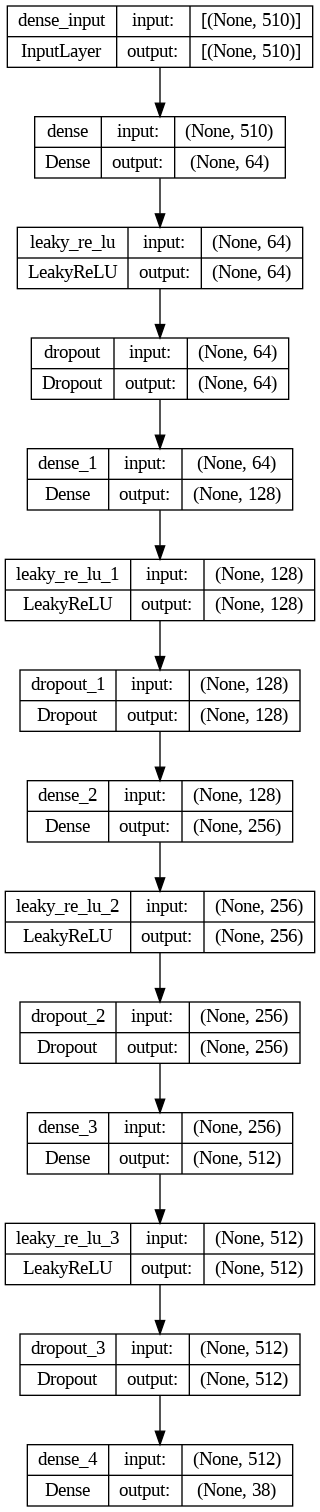

In [22]:
keras.utils.plot_model(generator, show_shapes = True, show_layer_names = True)

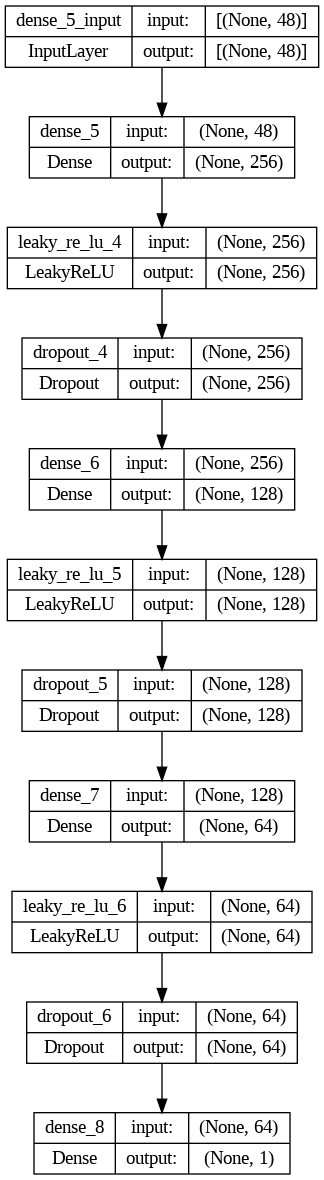

In [23]:
keras.utils.plot_model(discriminator, show_shapes = True, show_layer_names = True)

In [24]:
wcgan_gp = WCGAN_GP_VAE(
    discriminator = discriminator, 
    generator = generator, 
    latent_dim = latent_dim,
    anomaly_detector = anomaly_detector,
    use_anomaly_detector = True,
    discriminator_steps = 5, 
    gp_weight = 10
)

# Values of optimizers closely based on WGAN-GP paper
wcgan_gp.compile(
    d_optimizer = keras.optimizers.Adam(
        learning_rate = 0.0001, beta_1 = 0, beta_2 = 0.9, epsilon = 0.1
    ),
    g_optimizer = keras.optimizers.Adam(
        learning_rate = 0.0005, beta_1 = 0.5, beta_2 = 0.9, epsilon = 0.1
    )
)

In [25]:
batch_size = 2048
epochs = 100
dataset = tf.data.Dataset.from_tensor_slices((gan_train_x, gan_train_y)).shuffle(X_train.shape[0])
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [26]:
# Create a callbacks that plots training and saves model
plotting_callback = TrainingPlot()
checkpoint_callback = SaveOrLoadModel(
    checkpoint_path = f'{base_folder}/{wcgan_file}',
    restore_from_checkpoint = continue_train_wcgan,
    skip_train = not train_new_wcgan and not continue_train_wcgan,
    checkpoint_frequency = checkpoint_frequency_wcgan
)

if continue_train_wcgan:
    num_epochs = epochs - num_epochs_done_wcgan
else:
    num_epochs = epochs

history = wcgan_gp.fit(
    dataset, 
    batch_size = batch_size, 
    epochs = num_epochs,
    callbacks = [
        plotting_callback, 
        checkpoint_callback
    ]
)


Loading checkpoint /content/drive/MyDrive/Colab Notebooks/SEAS 6402/wcgan_model_new_v5_kdd/ckpt-100...done!
Epoch 1/100
39/39 [==============================] - 12s 9ms/step - g_loss: 0.1079 - d_loss: -0.0669 - d_cost: -0.0680


PIC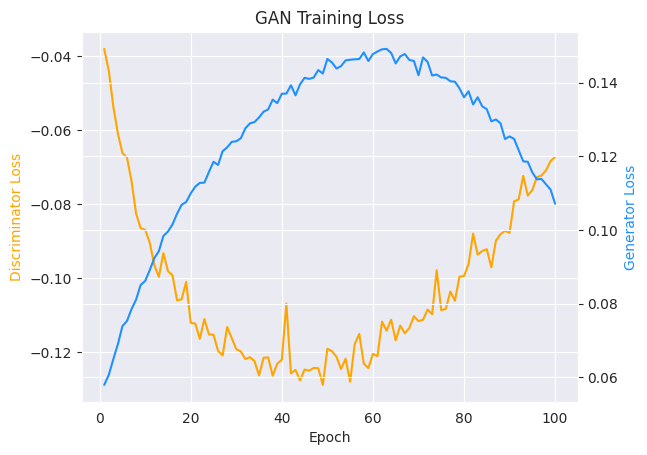

In [27]:
####################################
# Generator LOO Accuracy (Approx.) #
####################################
# Step 1: Get real data and give it a label of "1"
gan_test_x_real = pd.DataFrame(scaler.transform(X_test.copy()))
gan_test_x_real['label'] = 1

# Step 2: Generate fake data using trained generator and give it label of "0"
wcgan_trained_generator = wcgan_gp.generator
random_latent_vectors = tf.random.normal(
    shape = (gan_test_x_real.shape[0], latent_dim)
)
random_vector_labels = tf.concat(
    [random_latent_vectors, keras.utils.to_categorical(np.argmax(y_test_ohe, axis = 1))], 
    axis = 1
)
gan_test_x_gen = wcgan_trained_generator.predict(
    random_vector_labels
)
gan_test_x_gen = pd.DataFrame(
    gan_test_x_gen, 
    columns = gan_test_x_real.columns[:-1]
)
gan_test_x_gen['label'] = 0

# Step 3: Combine fake and real data.
gan_test_x = pd.concat(
    [gan_test_x_real, gan_test_x_gen], 
    ignore_index = True
)

# Step 4: Train 1-NN classifier and evaluate accuracy.
classifier = KNeighborsClassifier(n_neighbors = 1, n_jobs = -1)
scores = cross_val_score(
    classifier, 
    X = gan_test_x[gan_test_x.columns[:-1]] , 
    y = gan_test_x['label'], 
    scoring = 'accuracy',
    cv = 10000,
    verbose = 2
)
approx_loo_accuracy = scores.mean()

############################
# Mean Discriminator Score #
############################
# Step 1: Pass training data through anomaly detector
scores = anomaly_detector.predict_proba(gan_train_x)[:, 0]

# Step 2: Scale training data by probability of being non-anomalous
scaled_train_x = gan_train_x.mul(scores.reshape((-1, 1)), axis = 1)

# Step 3: Pass scaled features into trained discriminator to get mean and
#     standard deviation of scores
wcgan_trained_discriminator = wcgan_gp.discriminator
dis_scores = wcgan_trained_discriminator.predict(
    tf.concat([scaled_train_x, gan_train_y], -1)
)
mean_dis_score = dis_scores.mean()
std_dis_score = dis_scores.std()

print(f'GAN Evaluation:')
print(f'    Leave-One-Out Accuracy*:       {approx_loo_accuracy * 100:.2f}')
print(f'    Mean Discriminator Score:      {mean_dis_score:.2f}')
print(f'    Std. Dev. Discriminator Score: {std_dis_score:.2f}')

630/630 [==============================] - 1s 1ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................

[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  3.0min finished


2517/2517 [==============================] - 3s 1ms/step
GAN Evaluation:
    Leave-One-Out Accuracy*:       100.00
    Mean Discriminator Score:      -0.04
    Std. Dev. Discriminator Score: 0.01


### GAN Model 2: Vanilla GAN

In [28]:
gan_train_x = pd.DataFrame(scaler.transform(X_train.copy()))
gan_train_y = keras.utils.to_categorical(np.argmax(y_train_ohe, axis = 1)) 

display(gan_train_x.head())
display(gan_train_y[:5])

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-1.000000,-0.999644,-0.999676,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-0.866667,1.000000,1.00,-1.00,-0.88,-0.96,-1.0,-1.0,-1.0,-1.0
1,-0.999863,-0.998950,-0.999872,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,0.521569,-0.262745,-0.28,-0.92,-0.98,-0.96,-1.0,-1.0,-1.0,-1.0
2,-1.000000,-0.991636,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-0.192157,-0.050980,0.52,-0.90,0.52,-0.96,-1.0,-1.0,-1.0,-1.0
3,-1.000000,-0.999962,-0.999984,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.301961,-0.333333,0.92,-0.94,-0.98,-1.00,-1.0,-1.0,-1.0,-1.0
4,-0.906805,-0.999866,-0.999959,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.000000,-0.992157,-1.00,0.72,1.00,-1.00,-1.0,-1.0,-1.0,-1.0


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [29]:
num_cols = gan_train_x.shape[1]
latent_dim = 500
generator_input_size = latent_dim
discriminator_input_size = num_cols

generator = keras.models.Sequential([
    # Layer block 1
    keras.layers.Dense(64, input_shape = [generator_input_size]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.2),
    # Layer block 2
    keras.layers.Dense(128),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.2),
    # Layer block 3
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.2),
    # Layer block 4
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.2),
    # Final output
    keras.layers.Dense(num_cols, activation = 'tanh')
])

discriminator = keras.models.Sequential([
    # Layer block 1                                
    keras.layers.Dense(256, input_shape = [discriminator_input_size]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.5),
    # Layer block 2
    keras.layers.Dense(128),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.5),
    # Layer block 3
    keras.layers.Dense(64),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.5),
    # Final output
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [30]:
class GAN_VAE(keras.Model):
    '''Implementation of a vanilla GAN with a VAE scaler.

    This follows the standard implementation of GAN with the added
    modification of allowing a pre-trained VAE to sit between the generator
    and discriminator to appropriately scale the inputs to the discriminator
    by the probability of being non-anomalous.

    Attributes
    ----------
    discriminator : Keras Sequential model
        Discriminator model for the GAN

    generator : Keras Sequential model
        Generator model for the GAN

    latent_dim : int
        Number of latent dimensions for input into the generator

    anomaly_detector : PyOD VAE model
        Pre-trained VAE model from the PyOD library

    use_anomaly_detector : bool, default=False
        Whether to actually use the anomaly detector to scale
        discriminator inputs or not
    '''
    def __init__(
        self, 
        discriminator, 
        generator, 
        latent_dim, 
        anomaly_detector,
        use_anomaly_detector=False
    ):
        super(GAN_VAE, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.anomaly_detector = anomaly_detector
        self.use_anomaly_detector = use_anomaly_detector

    def compile(self, d_optimizer, g_optimizer):
        super(GAN_VAE, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @tf.function
    def get_anomaly_scores(self, data):
        '''Get probability of being non-anomalous from VAE.'''
        if self.use_anomaly_detector:
            scores = tf.py_function(
                self.anomaly_detector.predict_proba,
                [data],
                np.float32
            )[:, 0]
        else:
            scores = 1.0

        return scores

    # Binary cross-entropy loss functions
    def d_loss_fn(self, real_scores, fake_scores):
        '''Loss function for discriminator.'''
        loss = -tf.reduce_mean(tf.math.log(real_scores + 1e-10) \
            + tf.math.log(1. - fake_scores + 1e-10))

        return loss

    def g_loss_fn(self, fake_scores):
        '''Loss function for generator.'''
        return -tf.reduce_mean(tf.math.log(fake_scores + 1e-10))

    def train_step(self, data):
        real_data = data
        real_data = tf.cast(real_data, tf.float32)
        
        batch_size = tf.shape(real_data)[0]

        # Get the latent vector
        random_latent_vectors = tf.random.normal(
            shape = (batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            # Generate fake data from the latent vector
            generated_data = self.generator(
                random_latent_vectors, 
                training = True
            )

            # Pass fake data into anomaly detector 
            # to get probability of being non-anomalous
            scores = self.get_anomaly_scores(generated_data)
            scores = tf.expand_dims(scores, axis = -1)
            generated_data = generated_data * tf.stop_gradient(scores)

            # Get the scores for the fake data
            fake_scores = self.discriminator(
                generated_data, training = True
            )

            # Pass real data into anomaly detector 
            # to get probability of being non-anomalous
            scores = self.get_anomaly_scores(real_data)
            scores = tf.expand_dims(scores, axis = -1)
            real_data = real_data * tf.stop_gradient(scores)
            
            # Get the scores for the real data
            real_scores = self.discriminator(
                real_data, training = True
            )

            # Calculate the discriminator loss using the fake and real data scores
            d_loss = self.d_loss_fn(real_scores, fake_scores)

        # Get the gradients w.r.t the discriminator loss
        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update the weights of the discriminator using the discriminator optimizer
        self.d_optimizer.apply_gradients(
            zip(d_gradient, self.discriminator.trainable_variables)
        )

        with tf.GradientTape() as tape:
            # Generate fake data using the generator
            generated_data = self.generator(
                random_latent_vectors, training = True
            )

            # Pass fake data into anomaly detector 
            # to get probability of being anomalous
            scores = self.get_anomaly_scores(generated_data)
            scores = tf.expand_dims(scores, axis = -1)
            generated_data = generated_data * tf.stop_gradient(scores)

            # Get the discriminator scores for fake data
            fake_scores = self.discriminator(
                generated_data, 
                training = True
            )
            # Calculate the generator loss
            g_loss = self.g_loss_fn(fake_scores)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        # Monitor loss.
        return {
            'g_loss': g_loss, 
            'd_loss': d_loss  
        }

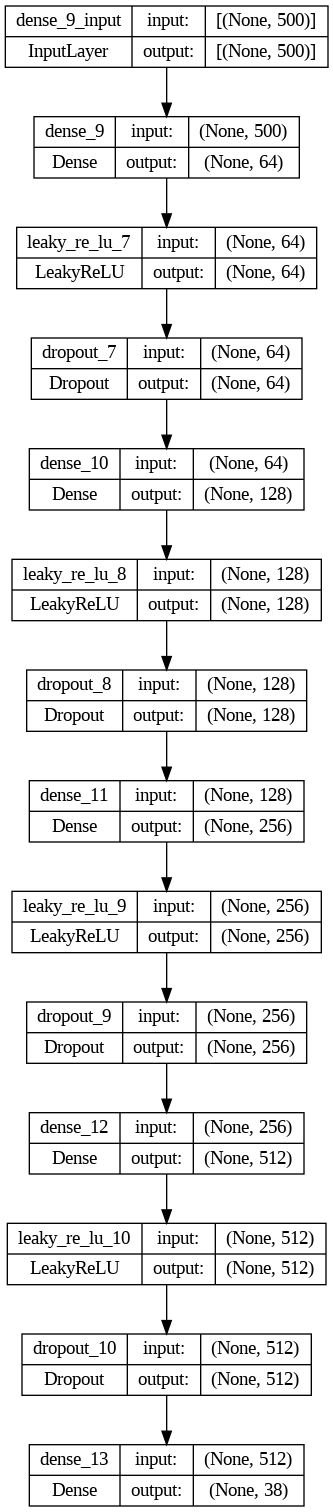

In [31]:
keras.utils.plot_model(generator, show_shapes = True, show_layer_names = True)

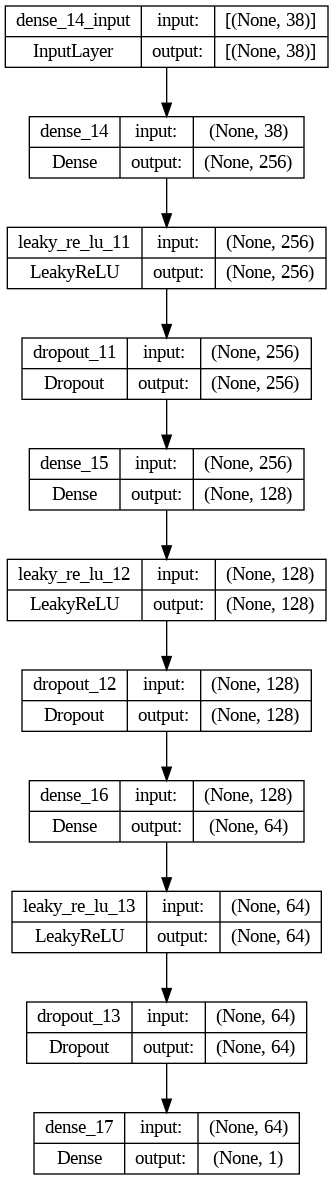

In [32]:
keras.utils.plot_model(discriminator, show_shapes = True, show_layer_names = True)

In [33]:
vanilla_gan = GAN_VAE(
    discriminator = discriminator, 
    generator = generator, 
    latent_dim = latent_dim,
    anomaly_detector = anomaly_detector,
    use_anomaly_detector = True
)

vanilla_gan.compile(
    d_optimizer = keras.optimizers.Adam(
        learning_rate = 0.0001, beta_1 = 0.5, beta_2 = 0.999, epsilon = 0.1
    ),
    g_optimizer = keras.optimizers.Adam(
        learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = 0.1
    )
)

In [34]:
batch_size = 2048
epochs = 100
dataset = tf.data.Dataset.from_tensor_slices(gan_train_x).shuffle(X_train.shape[0])
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

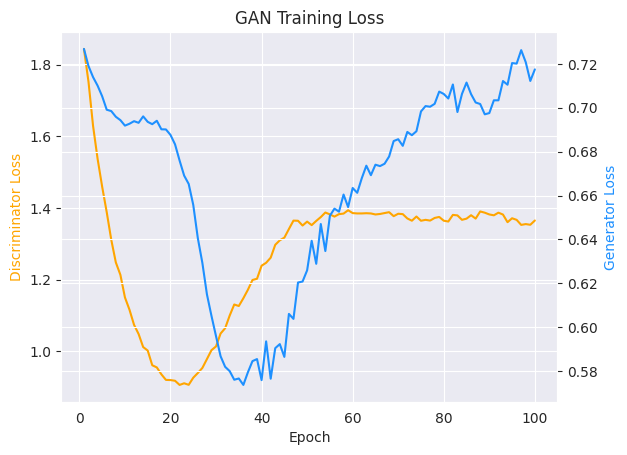


Saved checkpoint to /content/drive/MyDrive/Colab Notebooks/SEAS 6402/vgan_model_new_v5_kdd/ckpt-100!
39/39 [==============================] - 20s 503ms/step - g_loss: 0.7184 - d_loss: 1.3570


In [35]:
# Create a callbacks that plots training and saves model
plotting_callback = TrainingPlot()
checkpoint_callback = SaveOrLoadModel(
    checkpoint_path = f'{base_folder}/{vgan_file}',
    restore_from_checkpoint = continue_train_vgan,
    skip_train = not train_new_vgan and not continue_train_vgan,
    checkpoint_frequency = checkpoint_frequency_vgan
)

if continue_train_vgan:
    num_epochs = epochs - num_epochs_done_vgan
else:
    num_epochs = epochs

history = vanilla_gan.fit(
    dataset, 
    batch_size = batch_size, 
    epochs = num_epochs,
    callbacks = [
        plotting_callback, 
        checkpoint_callback
    ]
)

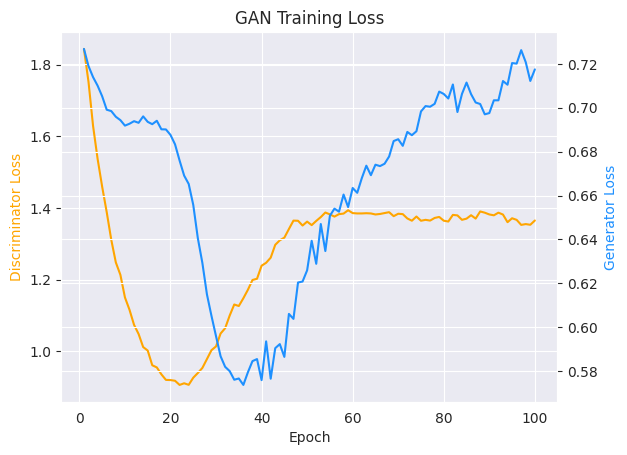

In [36]:
####################################
# Generator LOO Accuracy (Approx.) #
####################################
# Step 1: Get real data and give it a label of "1"
gan_test_x_real = pd.DataFrame(scaler.transform(X_test.copy()))
gan_test_x_real['label'] = 1

# Step 2: Generate fake data using trained generator and give it label of "0"
vgan_trained_generator = vanilla_gan.generator
random_latent_vectors = tf.random.normal(
    shape = (gan_test_x_real.shape[0], latent_dim)
)

gan_test_x_gen = vgan_trained_generator.predict(
    random_latent_vectors
)
gan_test_x_gen = pd.DataFrame(
    gan_test_x_gen, 
    columns = gan_test_x_real.columns[:-1]
)
gan_test_x_gen['label'] = 0

# Step 3: Combine fake and real data.
gan_test_x = pd.concat(
    [gan_test_x_real, gan_test_x_gen], 
    ignore_index = True
)

# Step 4: Train 1-NN classifier and evaluate accuracy.
classifier = KNeighborsClassifier(n_neighbors = 1, n_jobs = -1)
scores = cross_val_score(
    classifier, 
    X = gan_test_x[gan_test_x.columns[:-1]], 
    y = gan_test_x['label'], 
    scoring = 'accuracy',
    cv = 10000,
    verbose = 2
)
approx_loo_accuracy = scores.mean()

############################
#    Discriminator Score   #
############################
# Step 1: Pass test data through anomaly detector
scores = anomaly_detector.predict_proba(
    gan_test_x[gan_test_x.columns[:-1]]
)[:, 0]

# Step 2: Scale test data by probability of being an outlier
scaled_test_x = gan_test_x[gan_test_x.columns[:-1]] \
    .mul(scores.reshape((-1, 1)), axis = 1)

# Step 3: Pass scaled features into trained discriminator score
vgan_trained_discriminator = vanilla_gan.discriminator
dis_scores = vgan_trained_discriminator.predict(scaled_test_x)

print(f'GAN Evaluation:')
print(f'    Leave-One-Out Accuracy*:       {approx_loo_accuracy * 100:.2f}')
print('\n' + classification_report(gan_test_x['label'], np.round(dis_scores)))

630/630 [==============================] - 1s 1ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................

[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  3.2min finished


1259/1259 [==============================] - 2s 1ms/step
GAN Evaluation:
    Leave-One-Out Accuracy*:       100.00

              precision    recall  f1-score   support

           0       0.61      1.00      0.76     20131
           1       1.00      0.37      0.54     20131

    accuracy                           0.69     40262
   macro avg       0.81      0.69      0.65     40262
weighted avg       0.81      0.69      0.65     40262



## Testing Process

### WCGAN-GP

1259/1259 [==============================] - 1s 1ms/step
===========Logistic Regression (γ = 0)============
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     20131
           1       0.00      0.00      0.00     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262


==============Decision Tree (γ = 0)===============
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     20131
           1       0.00      0.00      0.00     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262

==========Logistic Regression (γ = 0.5)===========


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.30      0.28      0.29     20131
           1       0.32      0.34      0.33     20131

    accuracy                           0.31     40262
   macro avg       0.31      0.31      0.31     40262
weighted avg       0.31      0.31      0.31     40262


=============Decision Tree (γ = 0.5)==============
              precision    recall  f1-score   support

           0       0.49      0.64      0.56     20131
           1       0.49      0.34      0.40     20131

    accuracy                           0.49     40262
   macro avg       0.49      0.49      0.48     40262
weighted avg       0.49      0.49      0.48     40262

===========Logistic Regression (γ = 1)============
              precision    recall  f1-score   support

           0       0.54      0.18      0.27     20131
           1       0.51      0.84      0.63     20131

    accuracy                           0.51     40262
   macro avg       0.52  

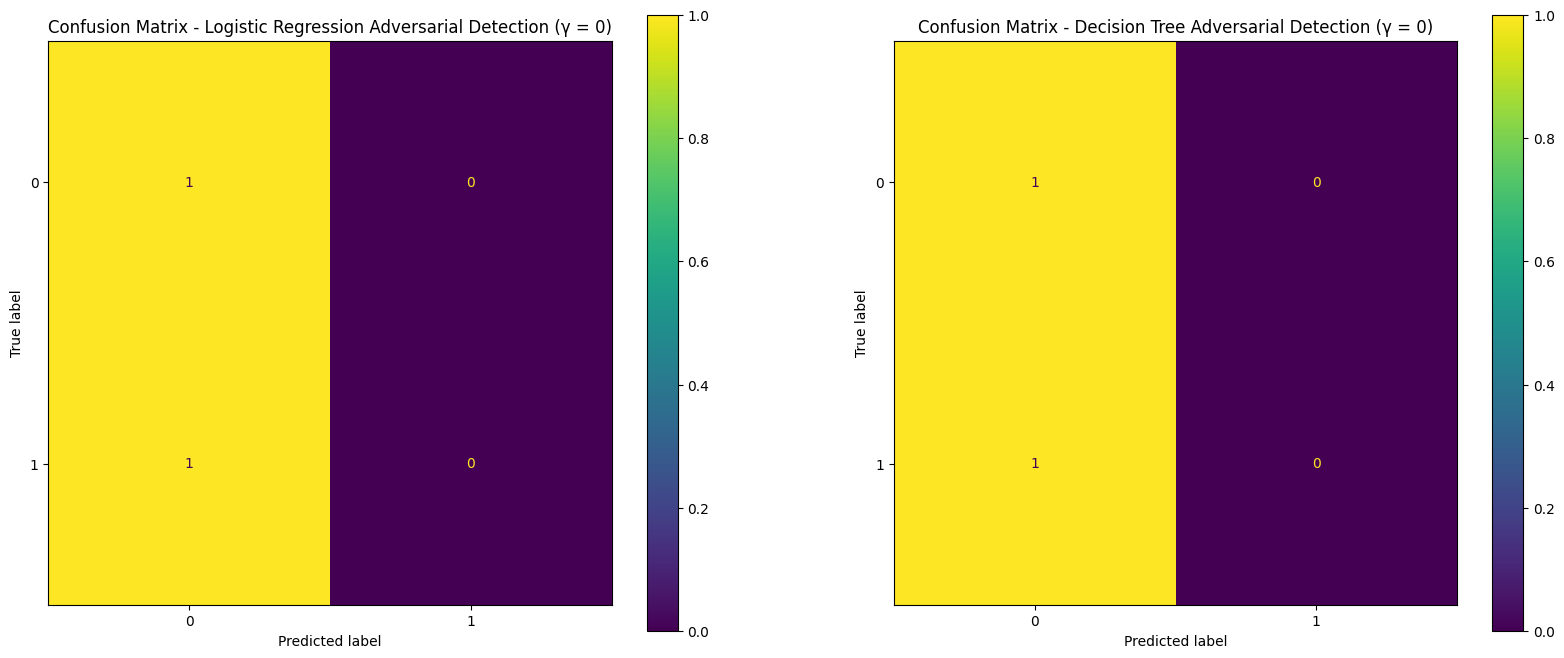

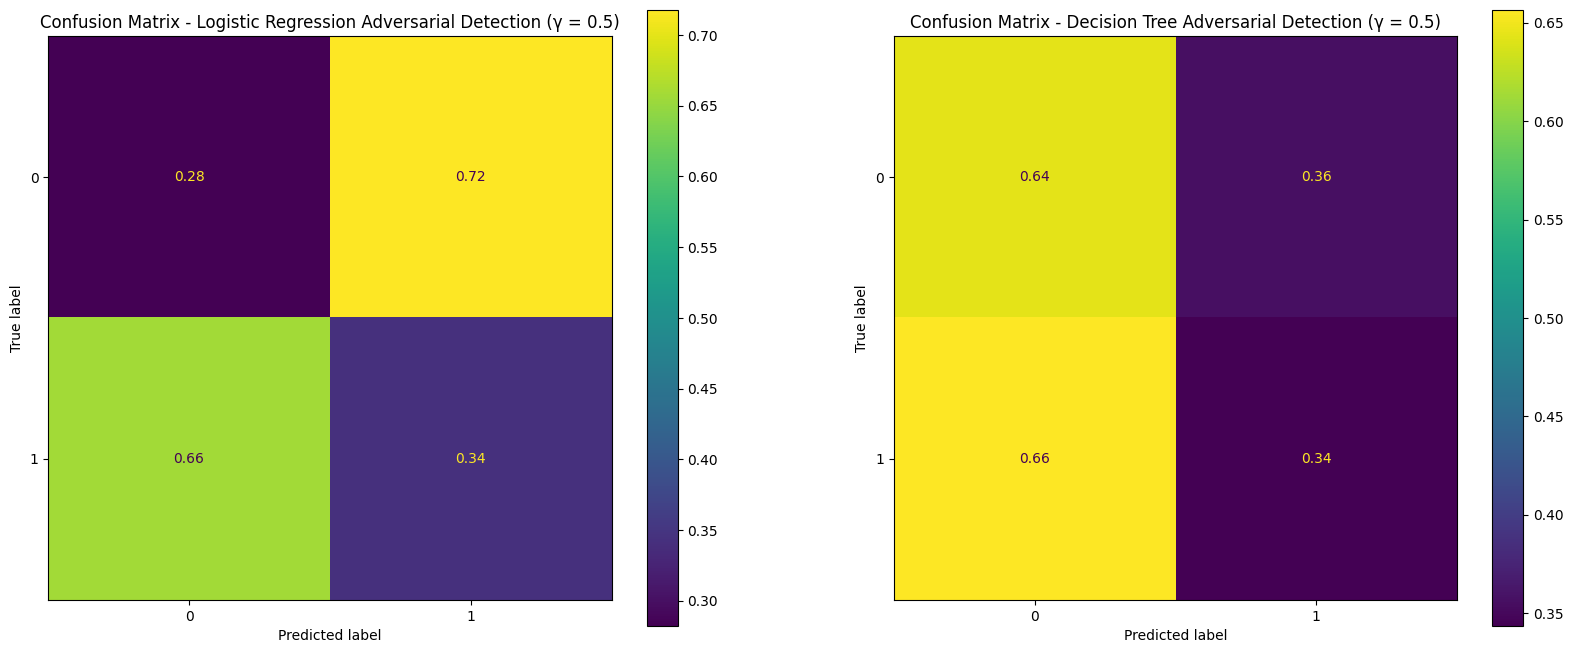

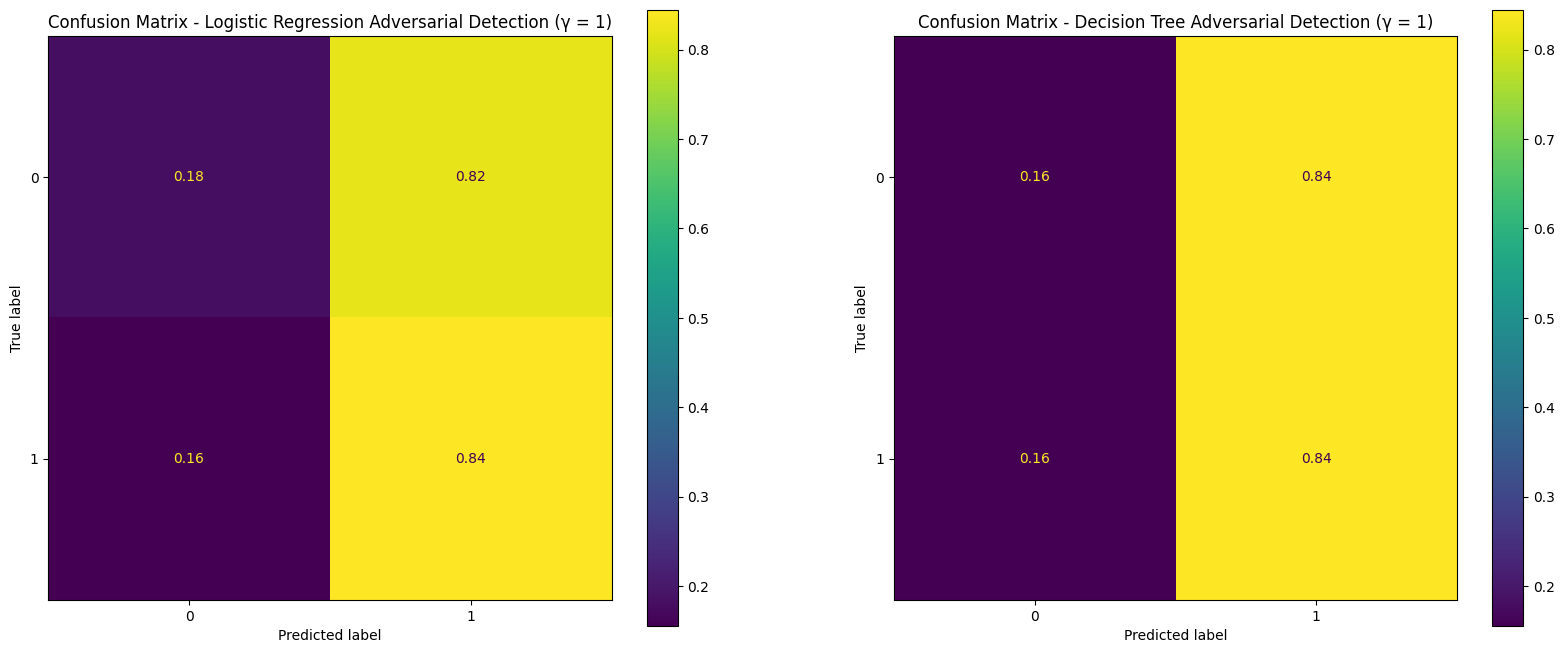

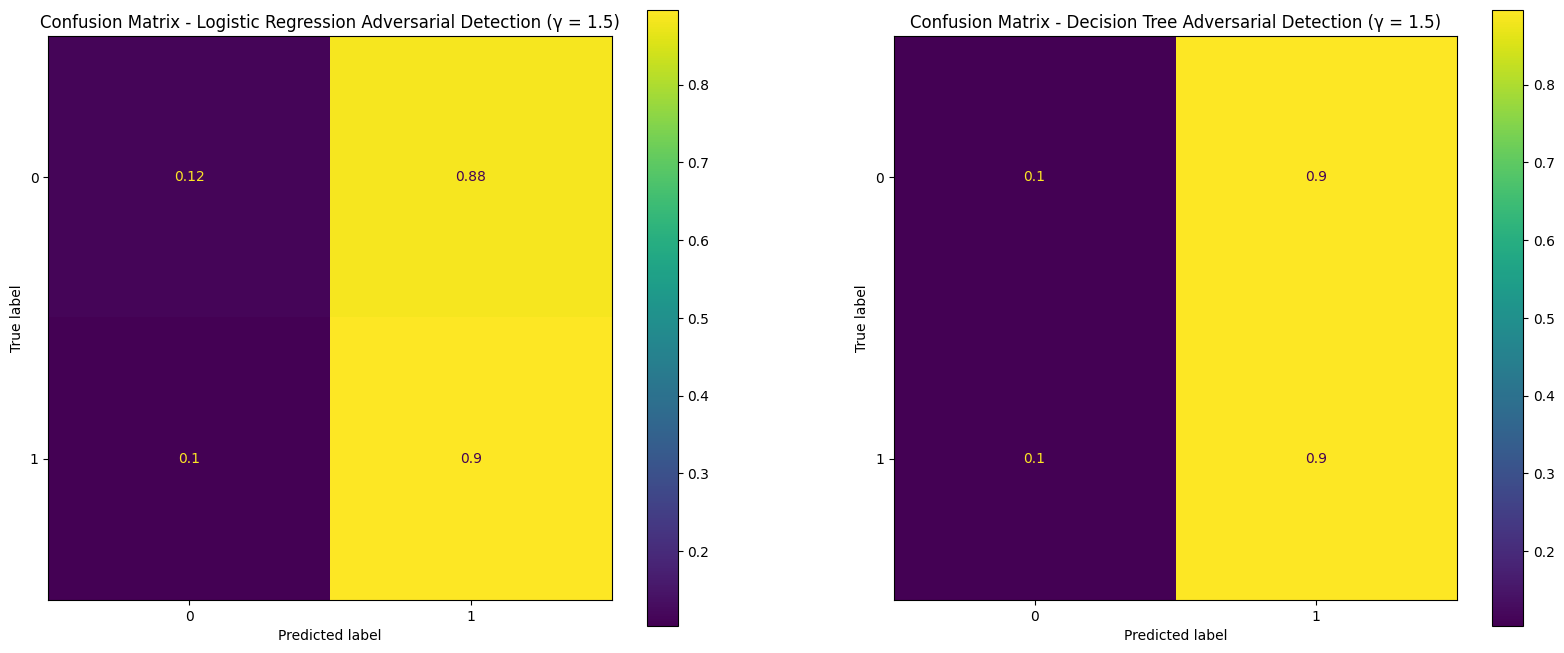

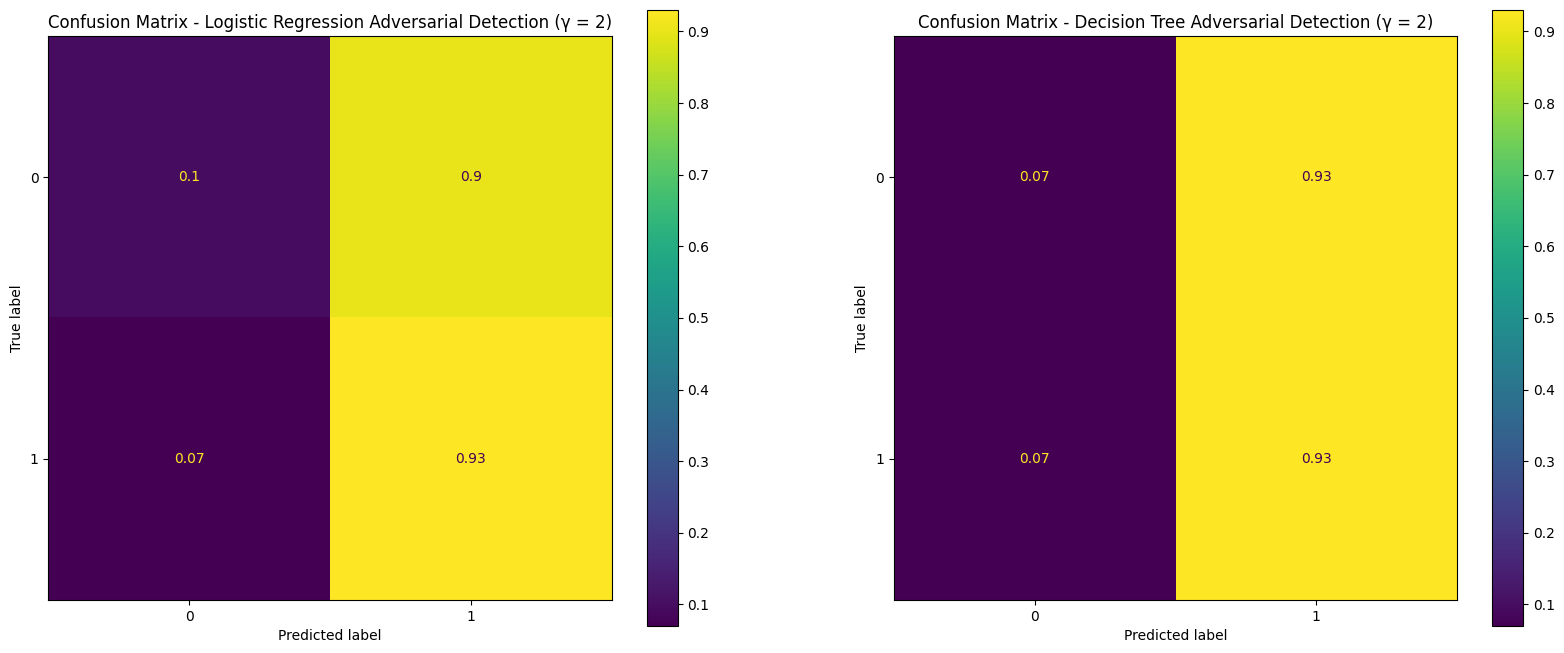

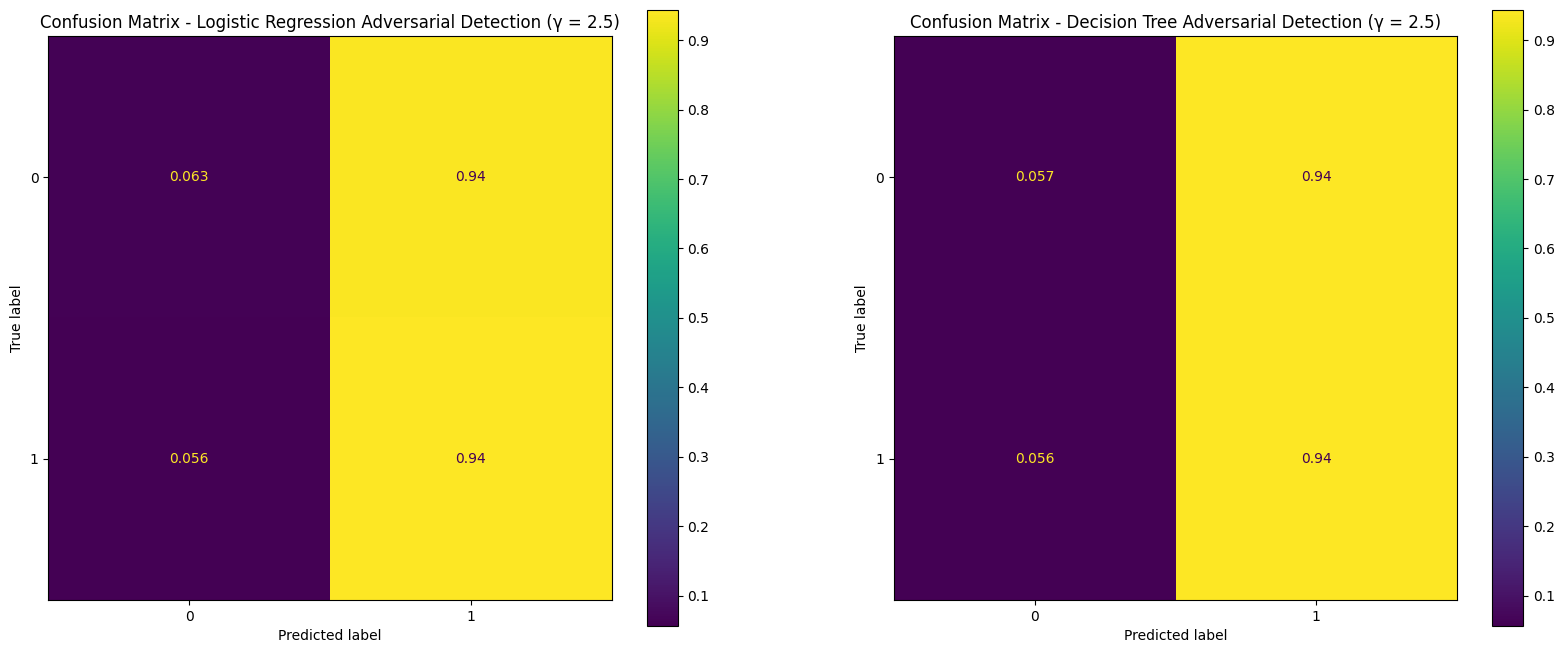

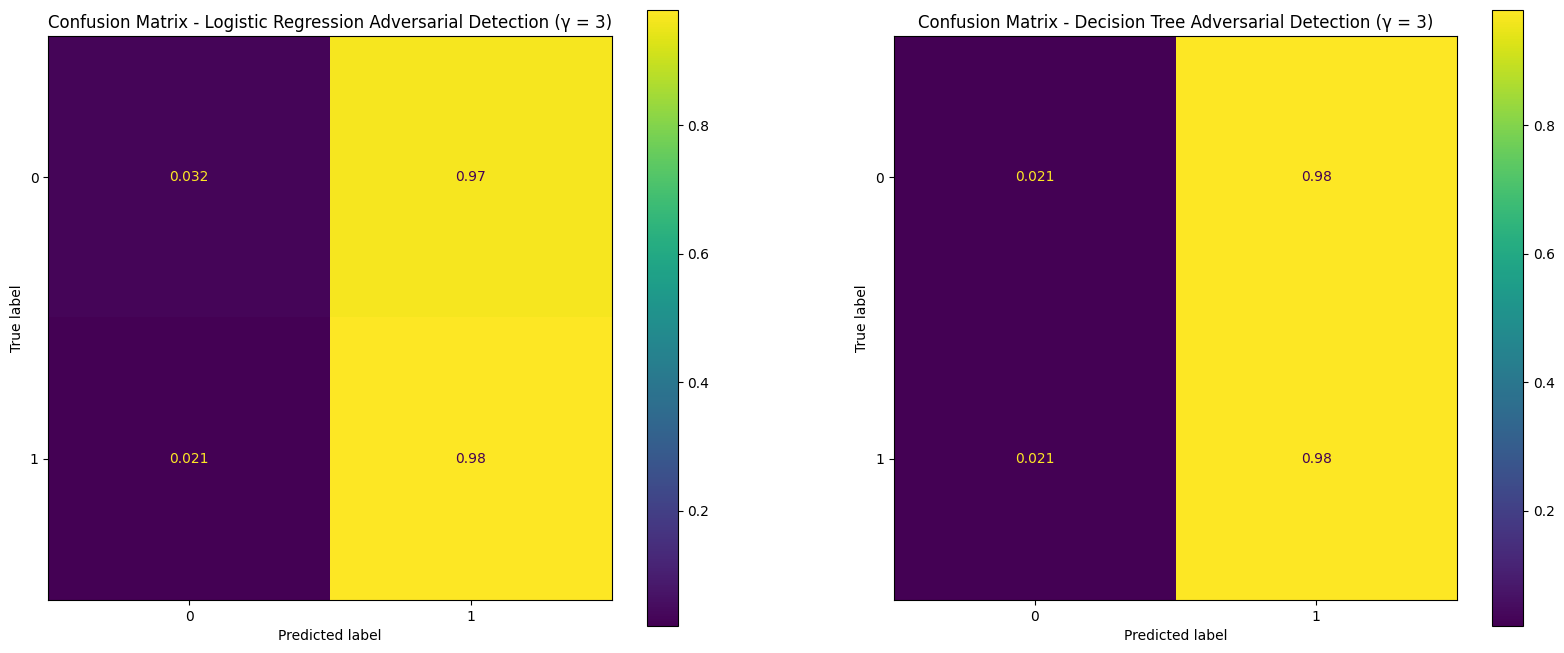

In [37]:
# Step 1: Get combined adversarial and true combined data.
#     X_test_adv_lr/dt already generated above
#     y_test_adv already generated above
# First half of data is adversarial examples, second half are real examples
y_fake_real_labels = np.array([0] * X_test.shape[0] + [1] * X_test.shape[0])

# Step 2: Pass data into VAE to get probability of being "normal."
scores_lr = anomaly_detector.predict_proba(X_test_adv_lr)[:, 0]
scores_dt = anomaly_detector.predict_proba(X_test_adv_dt)[:, 0]

# Step 3: Scale data based on probability.
X_test_scaled_lr = np.multiply(
    X_test_adv_lr,
    scores_lr.reshape((-1, 1))
)
X_test_scaled_dt = np.multiply(
    X_test_adv_dt, 
    scores_dt.reshape((-1, 1))
)

# Step 4: Pass data into discriminator.
dis_scores_lr = wcgan_trained_discriminator.predict(
    tf.concat([X_test_scaled_lr, lb.transform(y_test_adv)], -1)
)
dis_scores_dt = wcgan_trained_discriminator.predict(
    tf.concat([X_test_scaled_dt, lb.transform(y_test_adv)], -1)
)

# Step 5: Compare mean discriminator training discriminator score
#     - If sample score within `threshold` deviations of mean, it is "real"
#     - Else "fake"
for gamma in [0, 0.5, 1, 1.5, 2, 2.5, 3]:
    # Logistic regression
    X_test_df_lr = pd.DataFrame(
        np.concatenate([X_test_adv_lr, dis_scores_lr], axis = 1),
        columns = X_test.columns.tolist() + ['dis_score']
    )
    X_test_df_lr['is_real_pred'] = 0
    mask = np.where(
        (X_test_df_lr['dis_score'] > mean_dis_score - gamma * std_dis_score) &
        (X_test_df_lr['dis_score'] < mean_dis_score + gamma * std_dis_score)
    )[0]
    X_test_df_lr.loc[mask, 'is_real_pred'] = 1
    X_test_df_lr['is_real_actual'] = y_fake_real_labels

    # Decision tree
    X_test_df_dt = pd.DataFrame(
        np.concatenate([X_test_adv_dt, dis_scores_dt], axis = 1),
        columns = X_test.columns.tolist() + ['dis_score']
    )
    X_test_df_dt['is_real_pred'] = 0
    mask = np.where(
        (X_test_df_dt['dis_score'] > mean_dis_score - gamma * std_dis_score) &
        (X_test_df_dt['dis_score'] < mean_dis_score + gamma * std_dis_score)
    )[0]
    X_test_df_dt.loc[mask, 'is_real_pred'] = 1
    X_test_df_dt['is_real_actual'] = y_fake_real_labels

    print(f'Logistic Regression (γ = {gamma})'.center(50, '='))
    print(
        classification_report(
            X_test_df_lr['is_real_actual'], 
            X_test_df_lr['is_real_pred']
        )
    )

    print('\n' + f'Decision Tree (γ = {gamma})'.center(50, '='))
    print(
        classification_report(
            X_test_df_dt['is_real_actual'], 
            X_test_df_dt['is_real_pred']
        )
    )

    # Get confusion matrices
    fig, axes = plt.subplots(1, 2, figsize = (20, 8))
    axes[0].set_title(
        f'Confusion Matrix - Logistic Regression Adversarial Detection (γ = {gamma})'
    );
    ConfusionMatrixDisplay.from_predictions(
        X_test_df_lr['is_real_actual'], 
        X_test_df_lr['is_real_pred'], 
        normalize = 'true', 
        ax = axes[0]
    );

    axes[1].set_title(
        f'Confusion Matrix - Decision Tree Adversarial Detection (γ = {gamma})'
    );
    ConfusionMatrixDisplay.from_predictions(
        X_test_df_dt['is_real_actual'], 
        X_test_df_dt['is_real_pred'], 
        normalize = 'true', 
        ax = axes[1]
    );

### Vanilla GAN

1259/1259 [==============================] - 1s 1ms/step
==========Logistic Regression (γ = 0.01)==========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20131
           1       0.50      1.00      0.67     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262


=============Decision Tree (γ = 0.01)=============
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20131
           1       0.50      1.00      0.67     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

==========Logistic Regression (γ = 0.05)==========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20131
           1       0.50      1.00      0.67     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262


=============Decision Tree (γ = 0.05)=============
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20131
           1       0.50      1.00      0.67     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

==========Logistic Regression (γ = 0.1)===========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20131
           1       0.50      1.00      0.67     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262


=============Decision Tree (γ = 0.1)==============
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20131
           1       0.50      1.00      0.67     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

==========Logistic Regression (γ = 0.25)==========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20131
           1       0.50      1.00      0.67     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262


=============Decision Tree (γ = 0.25)=============
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20131
           1       0.50      1.00      0.67     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

==========Logistic Regression (γ = 0.5)===========
              precision    recall  f1-score   support

           0       0.52      0.69      0.60     20131
           1       0.55      0.37      0.44     20131

    accuracy                           0.53     40262
   macro avg       0.54      0.53      0.52     40262
weighted avg       0.54      0.53      0.52     40262


=============Decision Tree (γ = 0.5)==============
              precision    recall  f1-score   support

           0       0.49      0.61      0.55     20131
           1       0.49      0.37      0.42     20131

    accuracy                           0.49     40262
   macro avg       0.49      0.49      0.48     40262
weighted avg       0.49      0.49      0.48     40262

==========Logistic Regression (γ = 0.75)==========
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     20131
           1       0.00      0.00      0.00     20131

    accuracy                

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

==========Logistic Regression (γ = 0.99)==========
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     20131
           1       0.00      0.00      0.00     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262


=============Decision Tree (γ = 0.99)=============
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     20131
           1       0.00      0.00      0.00     20131

    accuracy                           0.50     40262
   macro avg       0.25      0.50      0.33     40262
weighted avg       0.25      0.50      0.33     40262



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

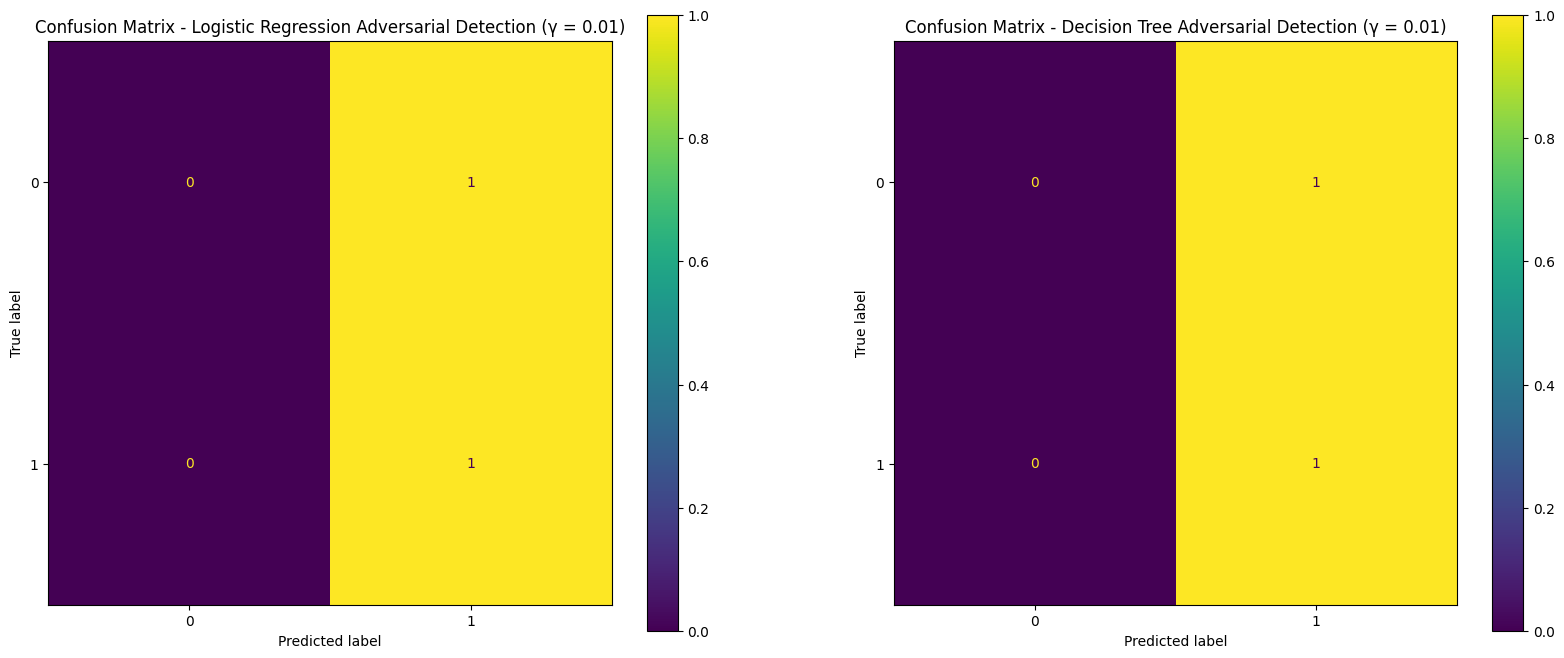

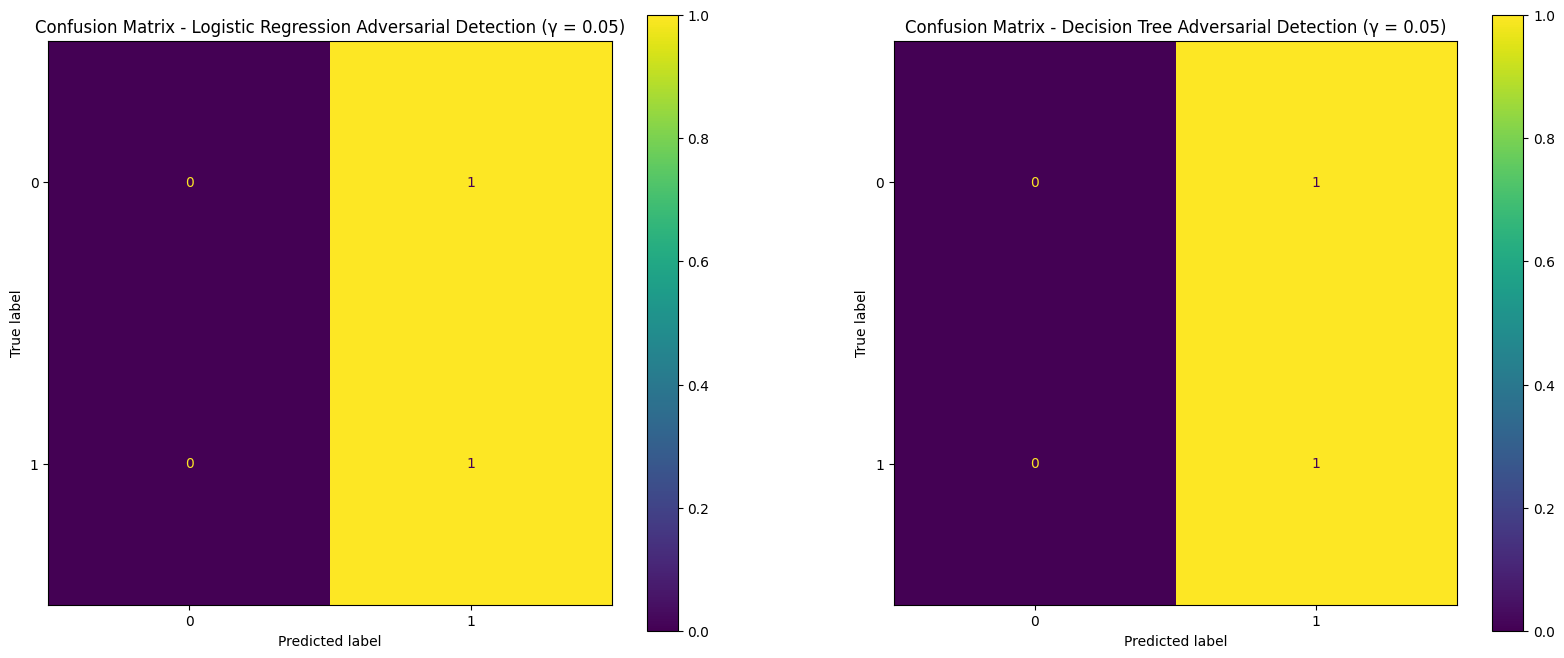

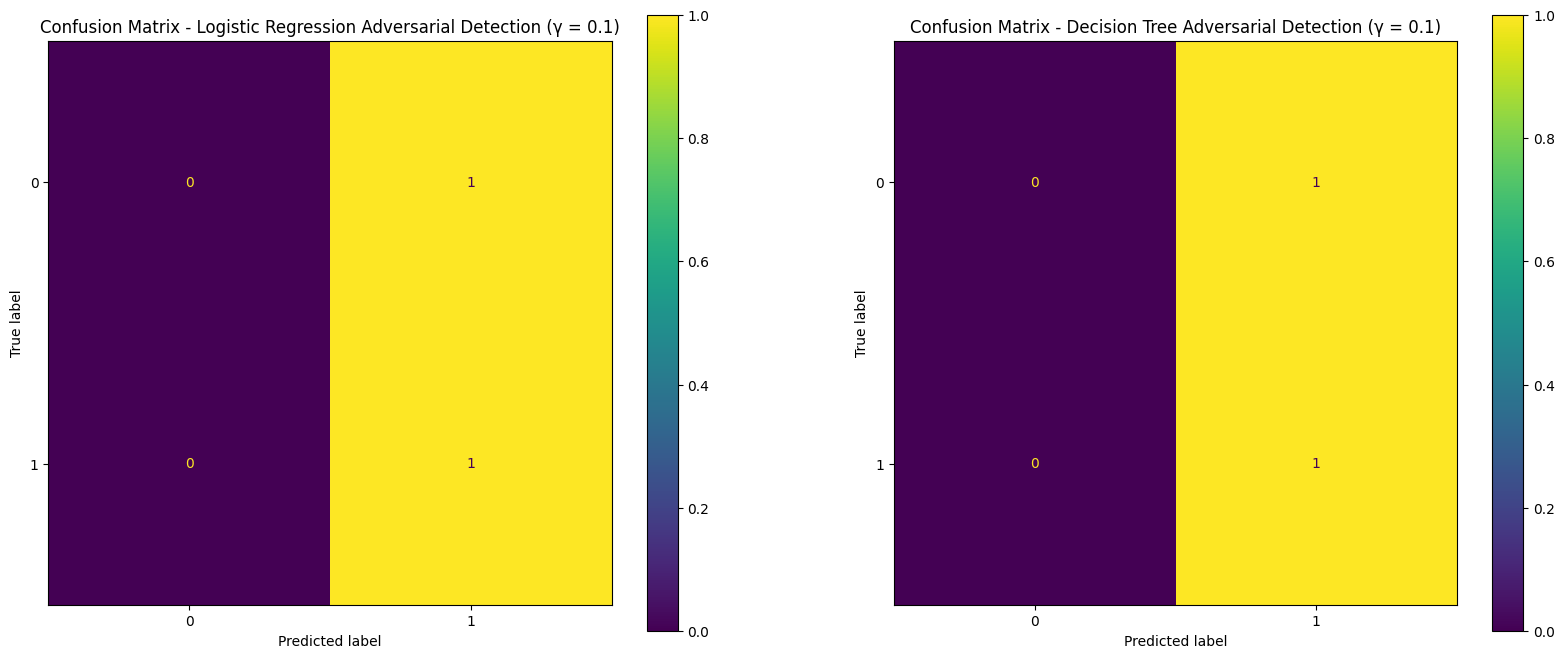

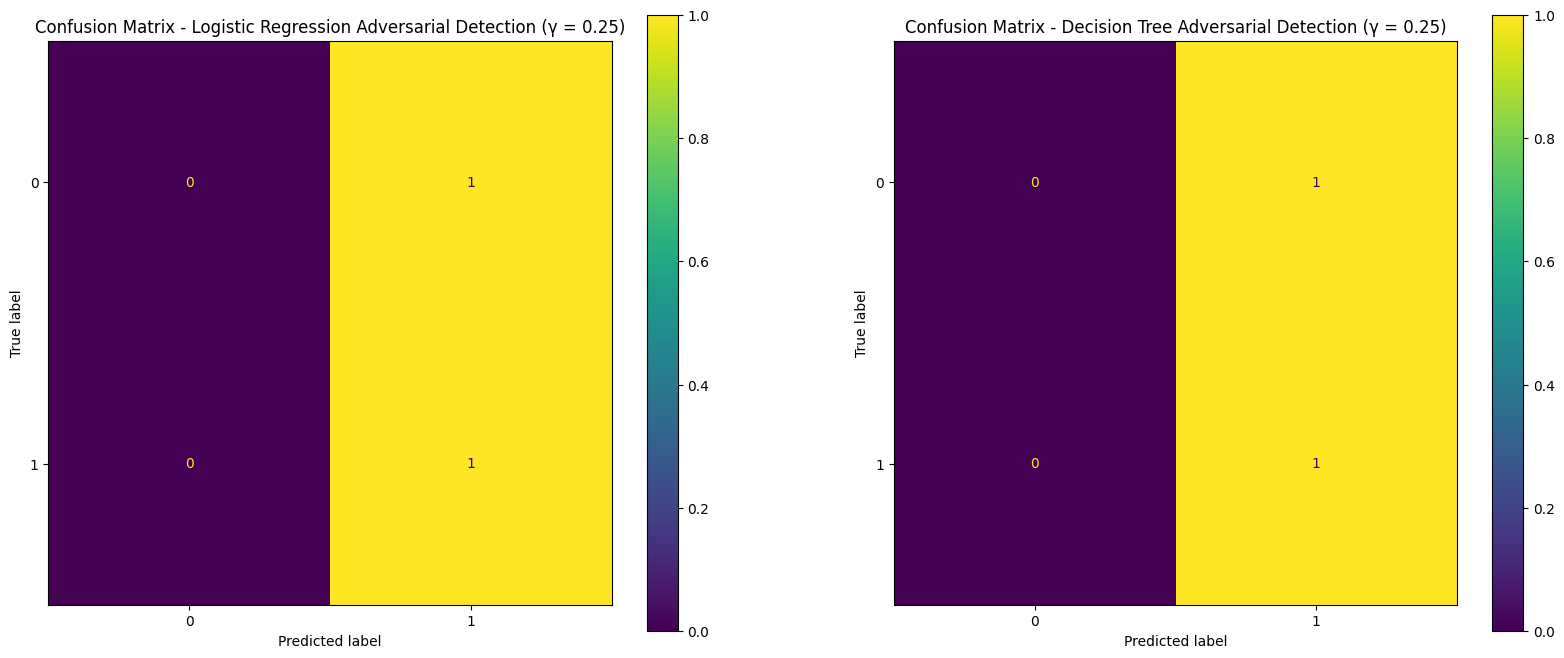

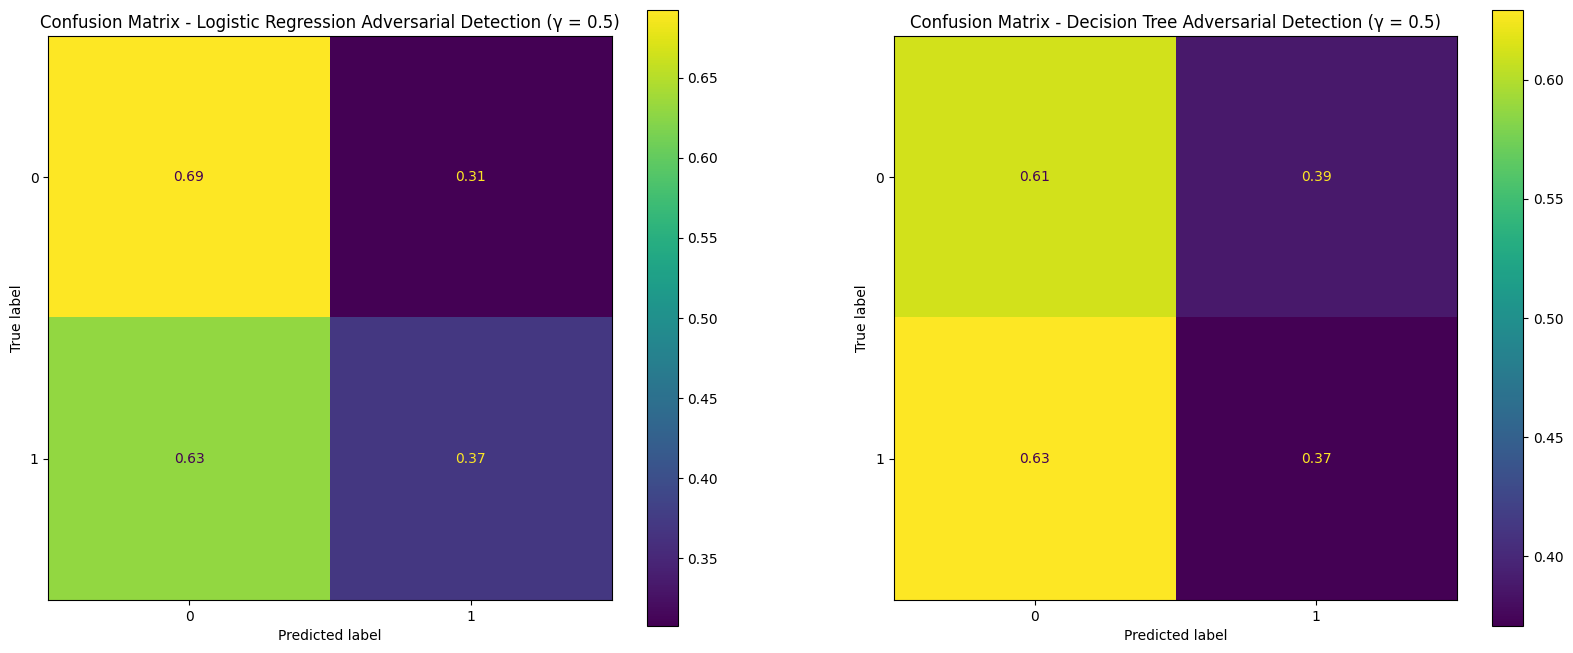

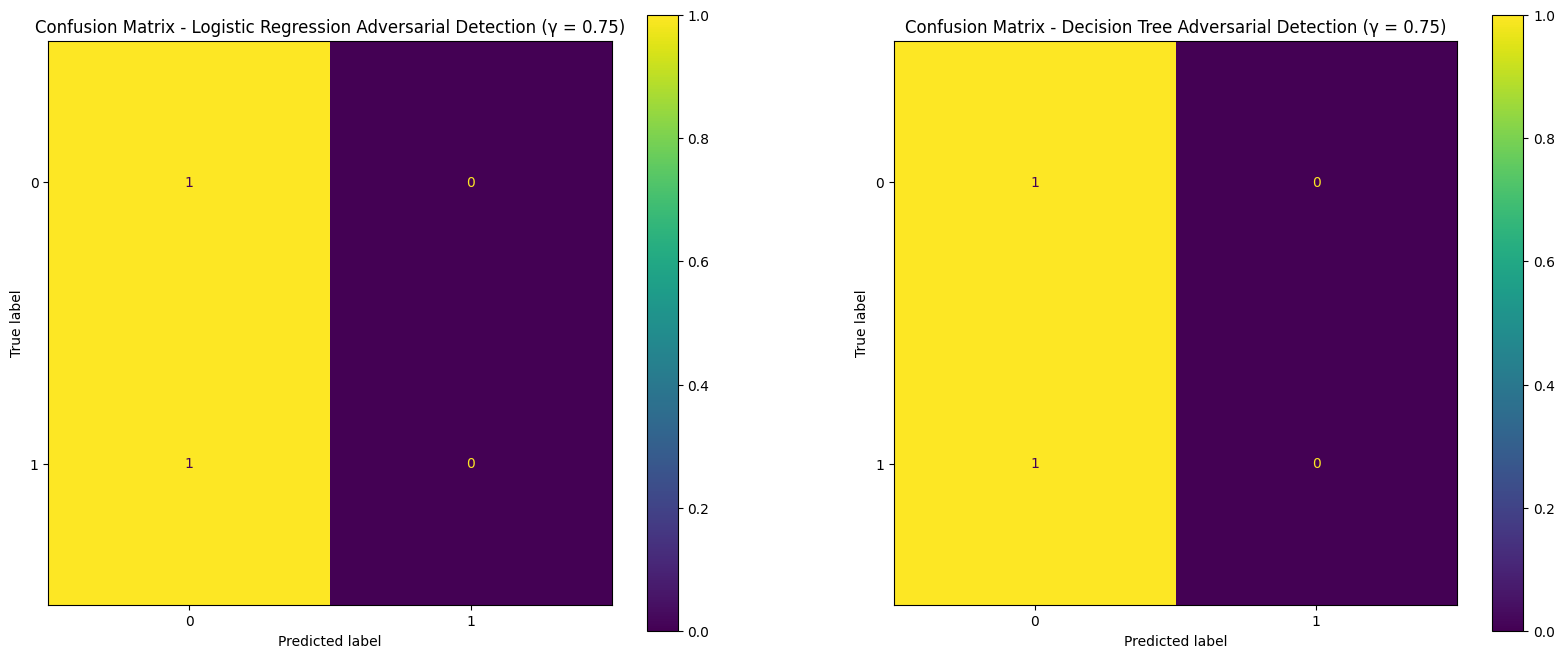

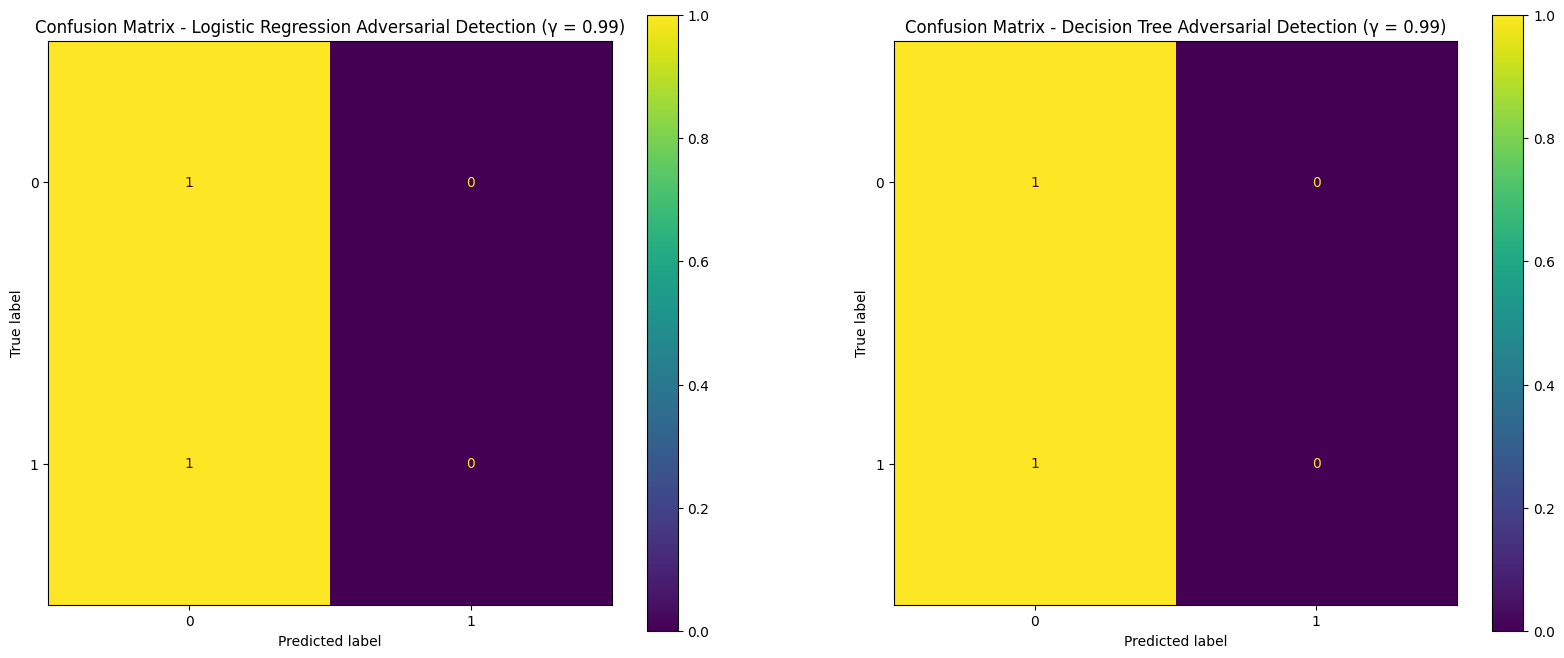

In [38]:
# Step 1: Get combined adversarial and true combined data.
#     X_test_adv_lr/dt already generated above
#     y_test_adv already generated above
# First half of data is adversarial examples, second half are real examples
y_fake_real_labels = np.array([0] * X_test.shape[0] + [1] * X_test.shape[0])

# Step 2: Pass data into VAE to get probability of being "normal."
scores_lr = anomaly_detector.predict_proba(X_test_adv_lr)[:, 0]
scores_dt = anomaly_detector.predict_proba(X_test_adv_dt)[:, 0]

# Step 3: Scale data based on probability.
X_test_scaled_lr = np.multiply(
    X_test_adv_lr,
    scores_lr.reshape((-1, 1))
)
X_test_scaled_dt = np.multiply(
    X_test_adv_dt, 
    scores_dt.reshape((-1, 1))
)

# Step 4: Pass data into discriminator.
dis_scores_lr = vgan_trained_discriminator.predict(X_test_scaled_lr)
dis_scores_dt = vgan_trained_discriminator.predict(X_test_scaled_dt)

# Step 5: Threshold discriminator score (since it's sigmoidal) to get label
for gamma in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.99]:
    # Logistic regression
    X_test_df_lr = pd.DataFrame(
        np.concatenate(
            [X_test_adv_lr, np.where(dis_scores_lr > gamma, 1, 0)], 
            axis = 1
        ),
        columns = X_test.columns.tolist() + ['is_real_pred']
    )
    X_test_df_lr['is_real_actual'] = y_fake_real_labels

    # Decision tree
    X_test_df_dt = pd.DataFrame(
        np.concatenate(
            [X_test_adv_dt, np.where(dis_scores_dt > gamma, 1, 0)], 
            axis = 1
        ),
        columns = X_test.columns.tolist() + ['is_real_pred']
    )
    X_test_df_dt['is_real_actual'] = y_fake_real_labels

    print(f'Logistic Regression (γ = {gamma})'.center(50, '='))
    print(
        classification_report(
            X_test_df_lr['is_real_actual'], 
            X_test_df_lr['is_real_pred']
        )
    )

    print('\n' + f'Decision Tree (γ = {gamma})'.center(50, '='))
    print(
        classification_report(
            X_test_df_dt['is_real_actual'], 
            X_test_df_dt['is_real_pred']
        )
    )

    # Get confusion matrices
    fig, axes = plt.subplots(1, 2, figsize = (20, 8))
    axes[0].set_title(
        f'Confusion Matrix - Logistic Regression Adversarial Detection (γ = {gamma})'
    );
    ConfusionMatrixDisplay.from_predictions(
        X_test_df_lr['is_real_actual'], 
        X_test_df_lr['is_real_pred'], 
        normalize = 'true', 
        ax = axes[0]
    );

    axes[1].set_title(
        f'Confusion Matrix - Decision Tree Adversarial Detection (γ = {gamma})'
    );
    ConfusionMatrixDisplay.from_predictions(
        X_test_df_dt['is_real_actual'], 
        X_test_df_dt['is_real_pred'], 
        normalize = 'true', 
        ax = axes[1]
    );